### `Import Libraries`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
tf.random.set_seed(42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

In [3]:
from scipy.stats import skew, kurtosis
from scipy.stats import norm
from scipy.stats import boxcox


### `Import Dataset`

In [4]:
data = pd.read_csv("./data/cardio.csv", delimiter=";", index_col="id")

### `Data Exploration`

In [5]:
data.sample(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,target
id,,,,,,,,,,,,
19485,21043,1,162,88.0,130,100,2,1,0,0,1,1
32356,22508,1,165,76.0,120,80,1,1,0,0,0,1
4931,20401,1,155,56.0,120,80,1,1,0,0,1,0
8170,22395,1,156,86.0,160,90,1,1,1,0,1,1
19239,19443,1,165,87.0,150,89,1,1,0,0,1,0


In [6]:
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")

Dataset contains 70000 rows and 12 columns.


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  target       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [8]:
data.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
target         0
dtype: int64

In [9]:
data.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,target
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
data["target"].value_counts()

target
0    35021
1    34979
Name: count, dtype: int64

In [11]:
data.groupby("target").mean()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
target,,,,,,,,,,,
0,18881.623711,1.345707,164.448017,71.592150,120.432598,84.251763,1.216527,1.175380,0.092516,0.055424,0.817881
1,20056.813031,1.353441,164.270334,76.822368,137.212042,109.023929,1.517396,1.277595,0.083736,0.052117,0.789559


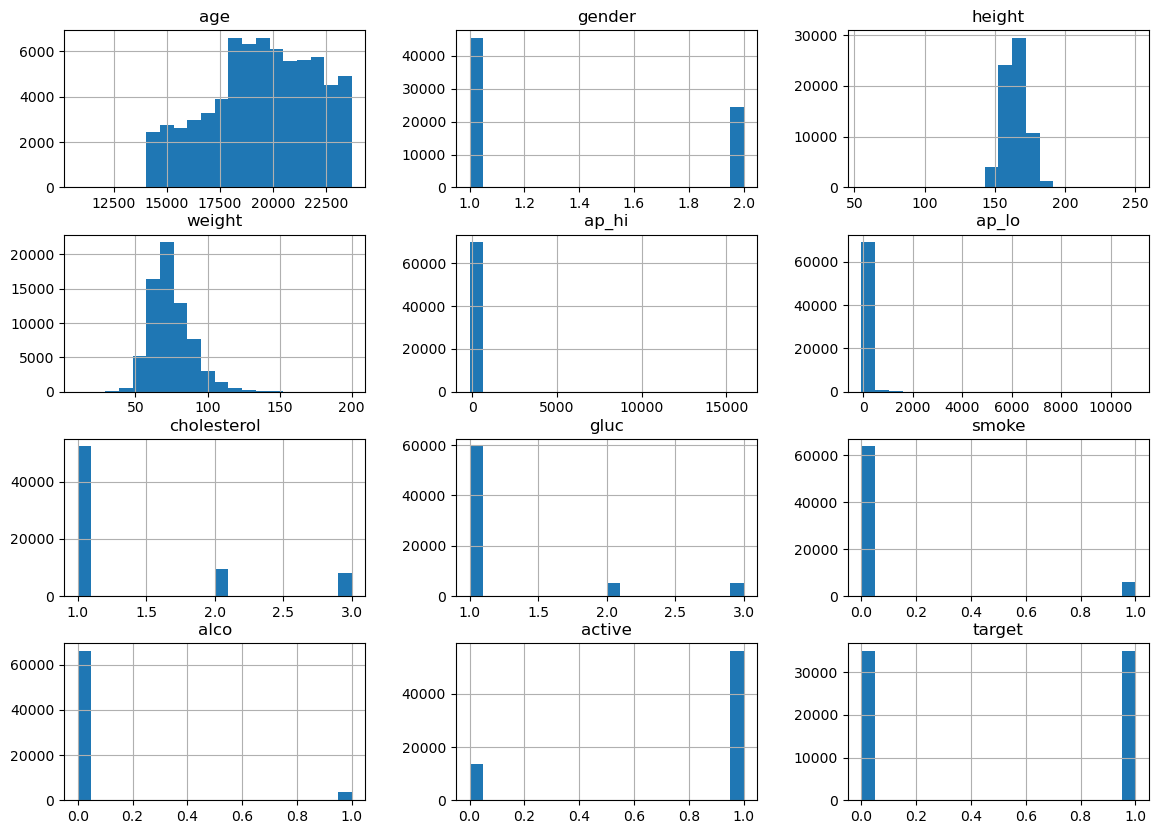

In [12]:
data.hist(bins=20, figsize=(14, 10))
plt.show()

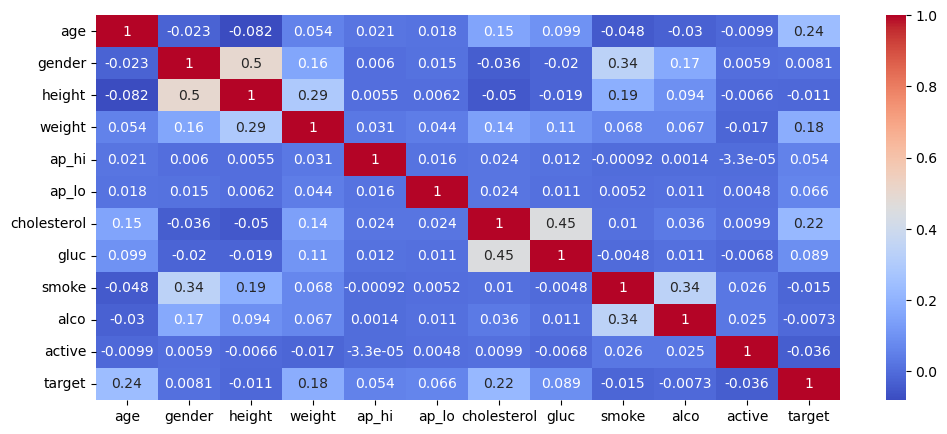

In [13]:
plt.figure(figsize=(12,5))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

### `Data Preprocessing`

#### `Processing Numerical Features`

##### `Functions`

In [14]:
def skew_kurtosis(df, feature_name):
    skewness = skew(df[feature_name])
    kurt = kurtosis(df[feature_name])
    print(f"Skewness: {skewness}, Kurtosis: {kurt}")

In [15]:
def plot_numerical_feature(df, feature_name):

    plt.figure(figsize=(16, 10))
    
    # 1. Histogram and normal distribution fit
    x = np.linspace(min(df[feature_name]), max(df[feature_name]), 100)
    y = norm.pdf(x, np.mean(df[feature_name]), np.std(df[feature_name]))
    
    plt.subplot(221)
    sns.histplot(df[feature_name], bins=30, color='blue', stat='density', label=f'{feature_name.capitalize()} Data')
    plt.plot(x, y, color="red", lw=3, label="Normal Distribution")
    plt.title(f'{feature_name.capitalize()} Distribution - Histogram')
    plt.legend(loc=2)

    # 2. Boxplot
    plt.subplot(222)
    sns.boxplot(x=df[feature_name], color='orange')
    plt.title(f'{feature_name.capitalize()} Outliers - Boxplot')

    # 3. Violin Plot
    plt.subplot(223)
    sns.violinplot(x=df[feature_name], color='purple')
    plt.title(f'{feature_name.capitalize()} Distribution - Violin Plot')

    # 4. Target-Wise Boxplot
    plt.subplot(224)
    sns.boxplot(x='target', y=feature_name, data=df, palette='Set2')
    plt.title(f'{feature_name.capitalize()} by Target - Boxplot')

    plt.tight_layout()
    plt.show()


In [16]:
def check_transform(df, feature_name):

    plt.figure(figsize=(14, 5))

    # 1. Histogram and normal distribution fit (sqrt)
    x = np.linspace(min(np.sqrt(df[feature_name])), max(np.sqrt(df[feature_name])), 100)
    y = norm.pdf(x, np.mean(np.sqrt(df[feature_name])), np.std(np.sqrt(df[feature_name])))
    
    plt.subplot(121)
    sns.histplot(np.sqrt(df[feature_name]), bins=30, color='blue', stat='density', label=f'{feature_name.capitalize()} Data')
    plt.plot(x, y, color="red", lw=3, label="Normal Distribution")
    plt.title(f'{feature_name.capitalize()} Distribution - Histogram (sqrt)')
    plt.legend(loc=2)

    # 2. Histogram and normal distribution fit (log)
    x = np.linspace(min(np.log1p(df[feature_name])), max(np.log1p(df[feature_name])), 100)
    y = norm.pdf(x, np.mean(np.log1p(df[feature_name])), np.std(np.log1p(df[feature_name])))
    
    plt.subplot(122)
    sns.histplot(np.log1p(df[feature_name]), bins=30, color='blue', stat='density', label=f'{feature_name.capitalize()} Data')
    plt.plot(x, y, color="red", lw=3, label="Normal Distribution")
    plt.title(f'{feature_name.capitalize()} Distribution - Histogram (log1p)')
    plt.legend(loc=2)

    plt.tight_layout()
    plt.show()


##### `age`

In [17]:
data['age'].describe()

count    70000.000000
mean     19468.865814
std       2467.251667
min      10798.000000
25%      17664.000000
50%      19703.000000
75%      21327.000000
max      23713.000000
Name: age, dtype: float64

In [18]:
data['age'] = (data['age'] // 365)

In [19]:
data['age'].describe()

count    70000.000000
mean        52.840671
std          6.766774
min         29.000000
25%         48.000000
50%         53.000000
75%         58.000000
max         64.000000
Name: age, dtype: float64

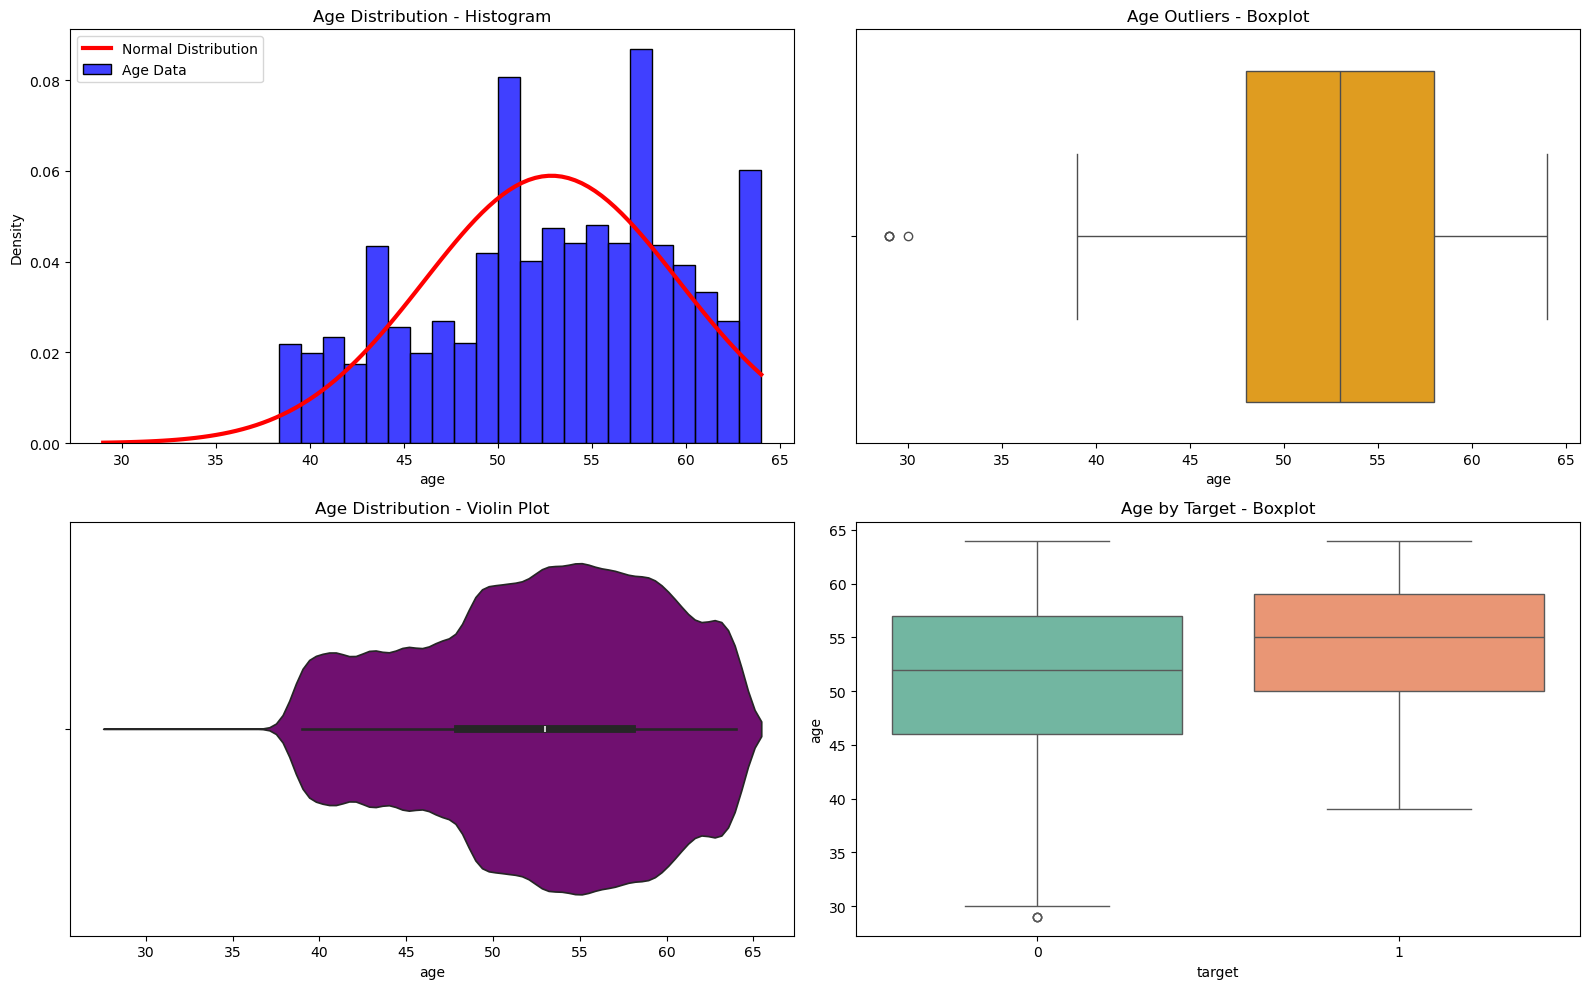

In [20]:
plot_numerical_feature(data, 'age')

In [21]:
skew_kurtosis(data, 'age')

Skewness: -0.3057373469819291, Kurtosis: -0.819008135268497


In [22]:
print(data['age'].quantile([0.001, 0.01, 0.99, 0.999]))

0.001    39.0
0.010    39.0
0.990    64.0
0.999    64.0
Name: age, dtype: float64


In [23]:
data = data[(data['age'] >= 32)]
print(data.shape)

(69996, 12)


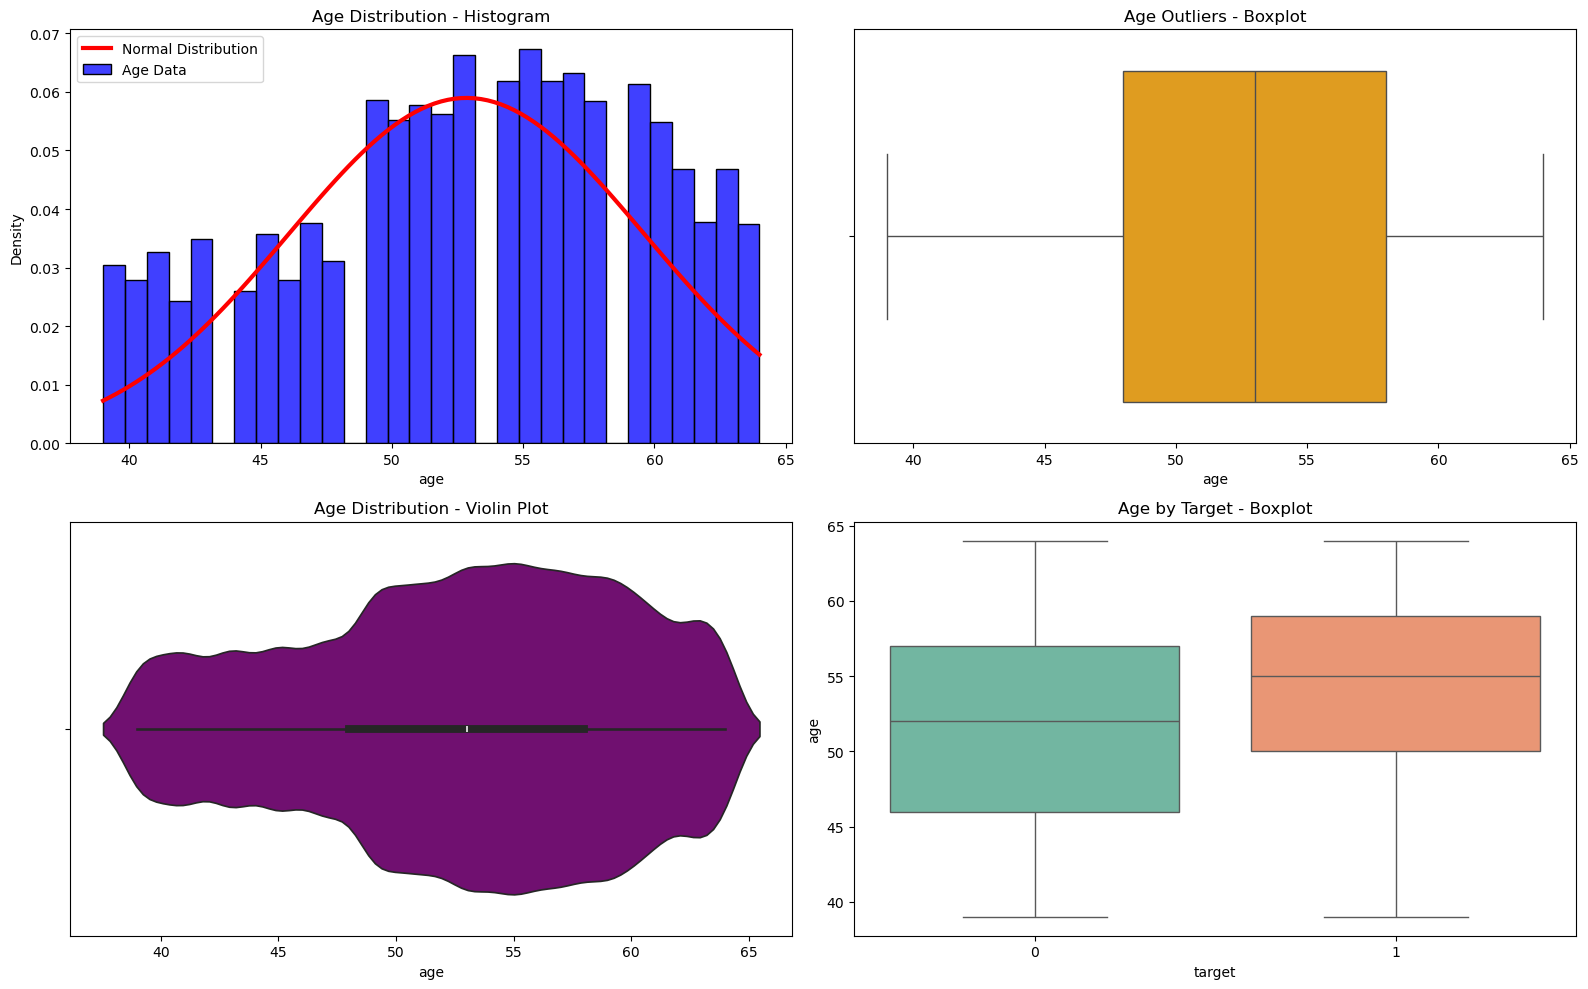

In [24]:
plot_numerical_feature(data, 'age')

In [25]:
skew_kurtosis(data, 'age')

Skewness: -0.3042192074115731, Kurtosis: -0.8243262172361123


##### `height`

In [26]:
data['height'].describe()

count    69996.000000
mean       164.359063
std          8.210122
min         55.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        250.000000
Name: height, dtype: float64

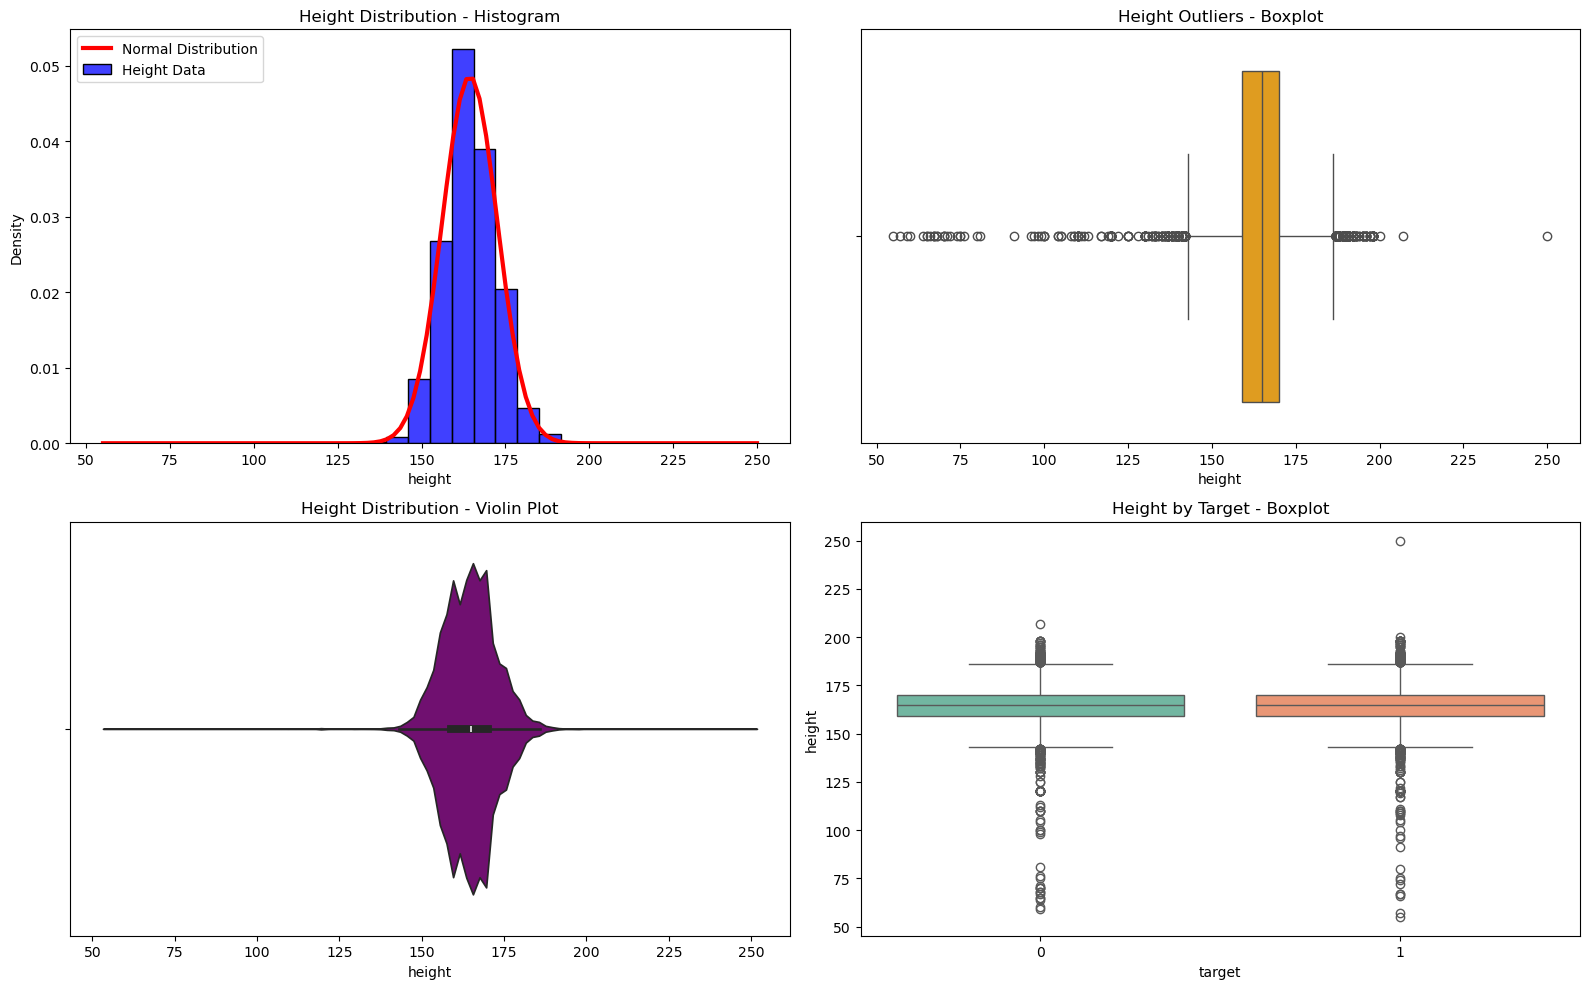

In [27]:
plot_numerical_feature(data, 'height')

In [28]:
skew_kurtosis(data, 'height')

Skewness: -0.6422070499058173, Kurtosis: 7.943509921816792


In [29]:
print(data['height'].quantile([0.001, 0.01, 0.99, 0.999]))

0.001    120.0
0.010    147.0
0.990    184.0
0.999    190.0
Name: height, dtype: float64


In [30]:
data = data[(data['height'] >= 130) & (data['height'] <= 190)]
print(data.shape)

(69840, 12)


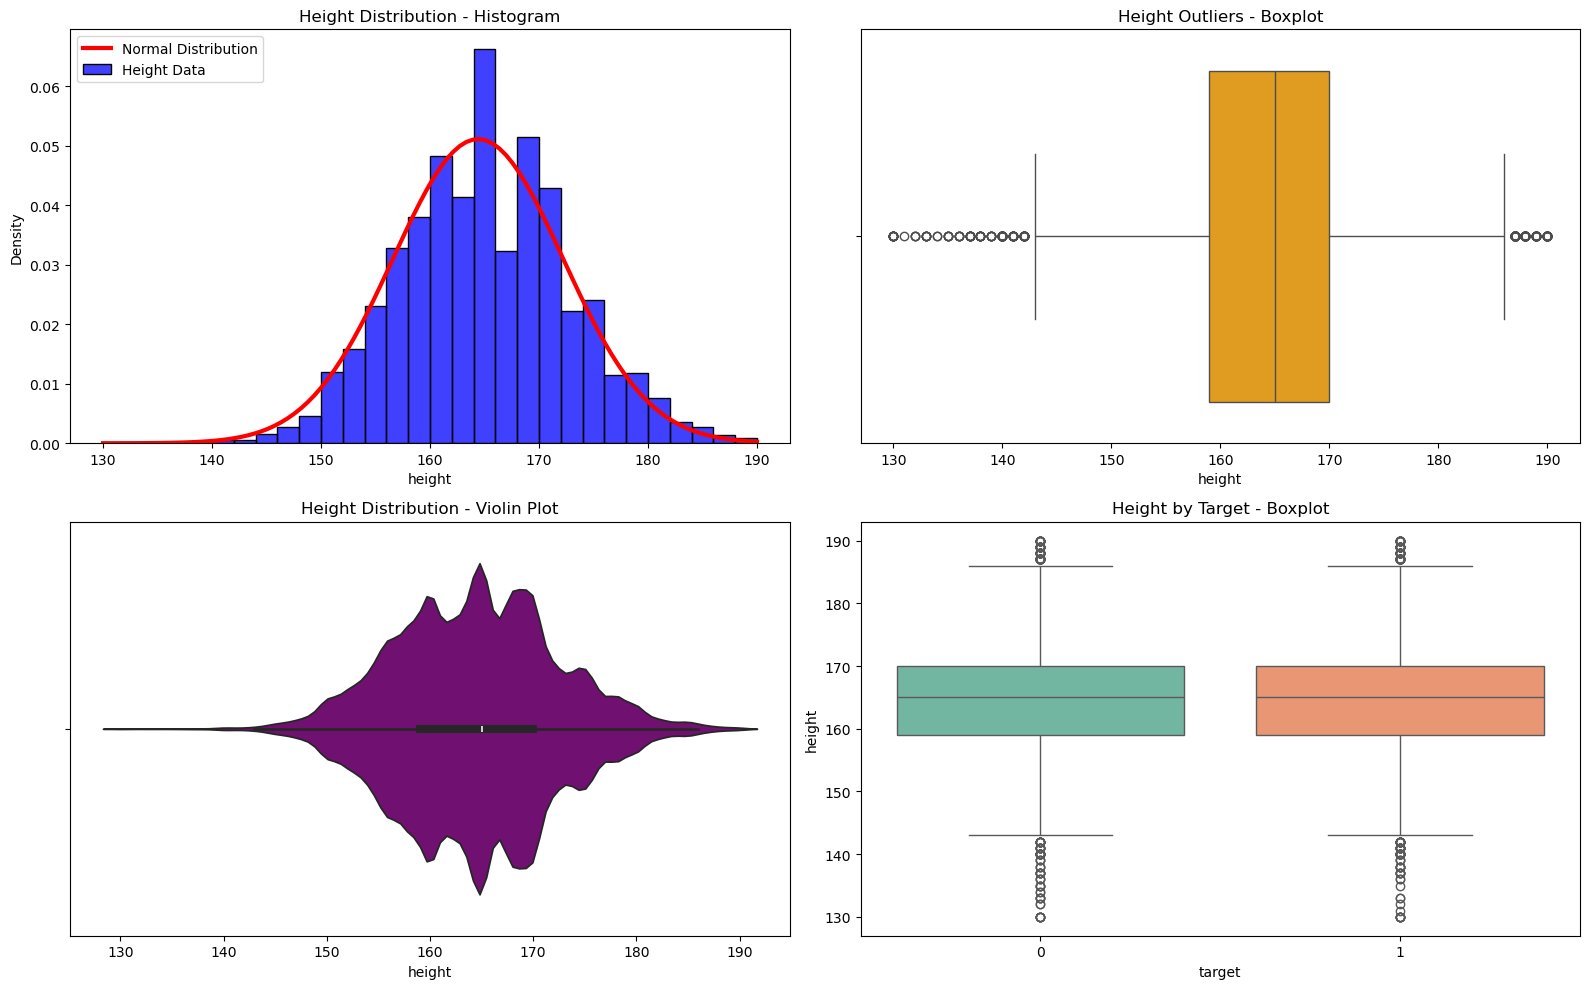

In [31]:
plot_numerical_feature(data, 'height')

In [32]:
skew_kurtosis(data, 'height')

Skewness: 0.07413900621723424, Kurtosis: 0.05645092272451002


##### `weight`

In [33]:
data['weight'].describe()

count    69840.000000
mean        74.182985
std         14.348139
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: weight, dtype: float64

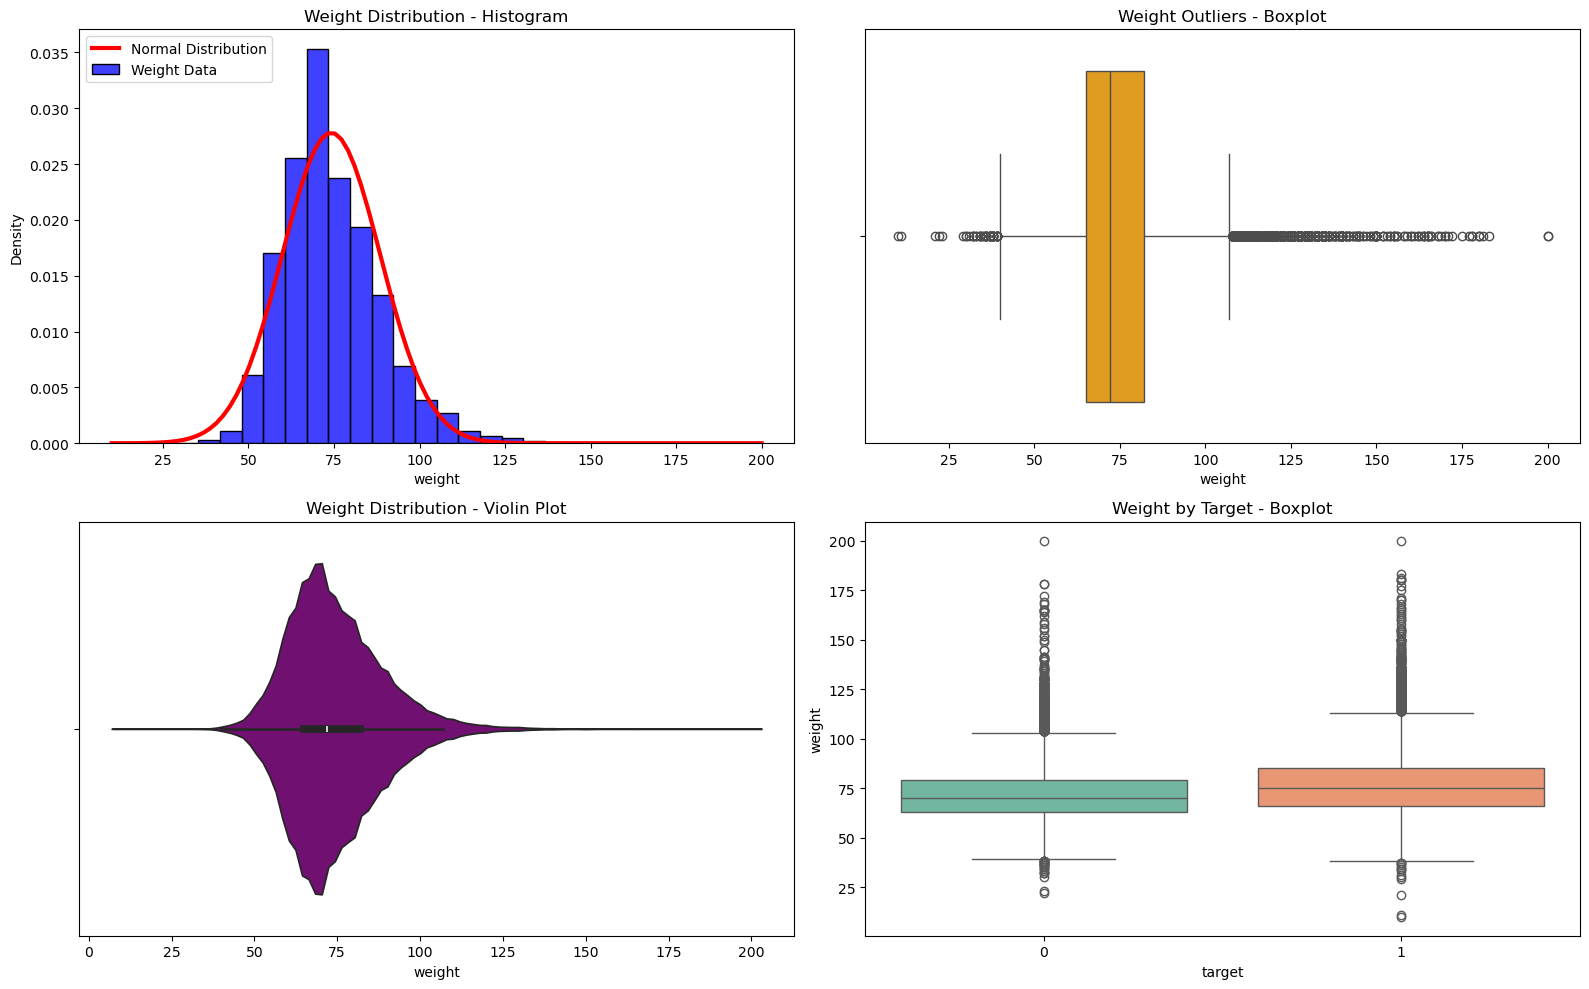

In [34]:
plot_numerical_feature(data, 'weight')

In [35]:
skew_kurtosis(data, 'weight')

Skewness: 0.9862904721449195, Kurtosis: 2.4028512421873245


In [36]:
print(data['weight'].quantile([0.001, 0.01, 0.99, 0.999]))

0.001     40.000
0.010     48.000
0.990    117.000
0.999    145.161
Name: weight, dtype: float64


In [37]:
data = data[(data['weight'] >= 40) & (data['weight'] <= 140)]
print(data.shape)

(69702, 12)


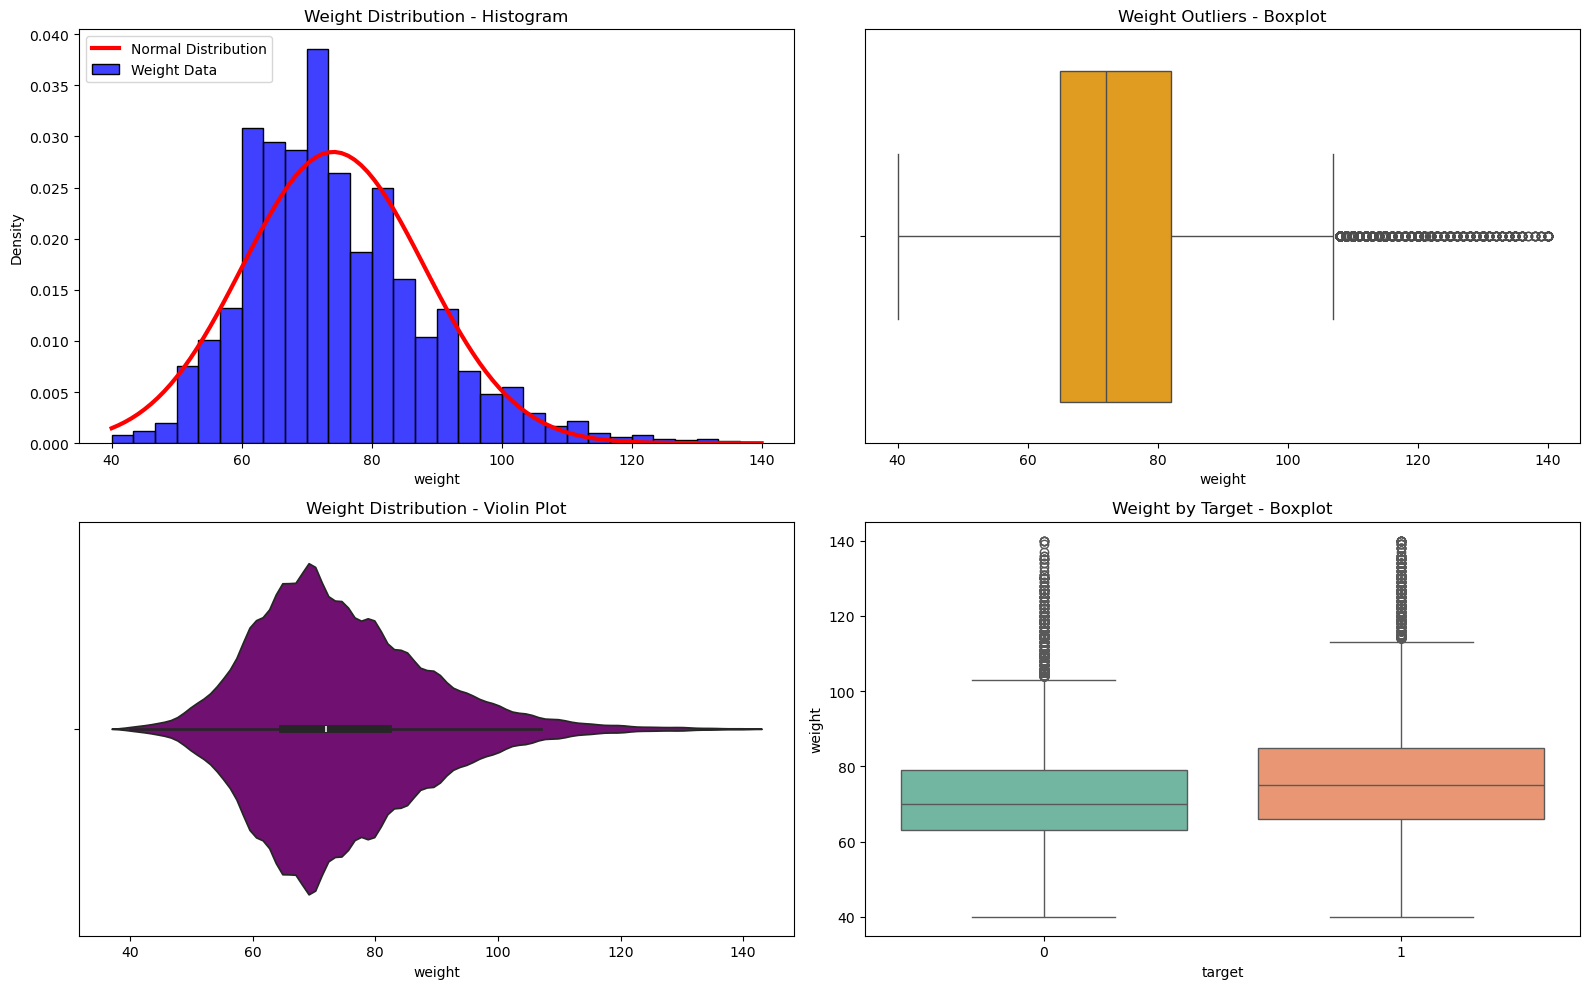

In [38]:
plot_numerical_feature(data, 'weight')

In [39]:
skew_kurtosis(data, 'weight')

Skewness: 0.8120716086929952, Kurtosis: 1.0908317142197328


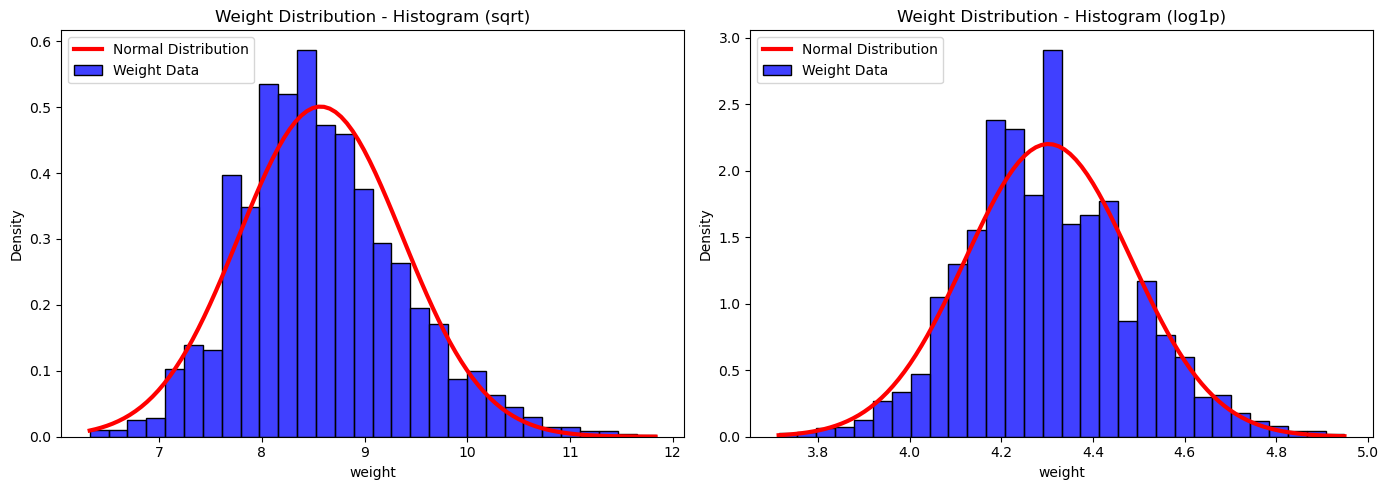

In [40]:
check_transform(data, 'weight')

In [41]:
data['weight'] = np.log1p(data['weight'])

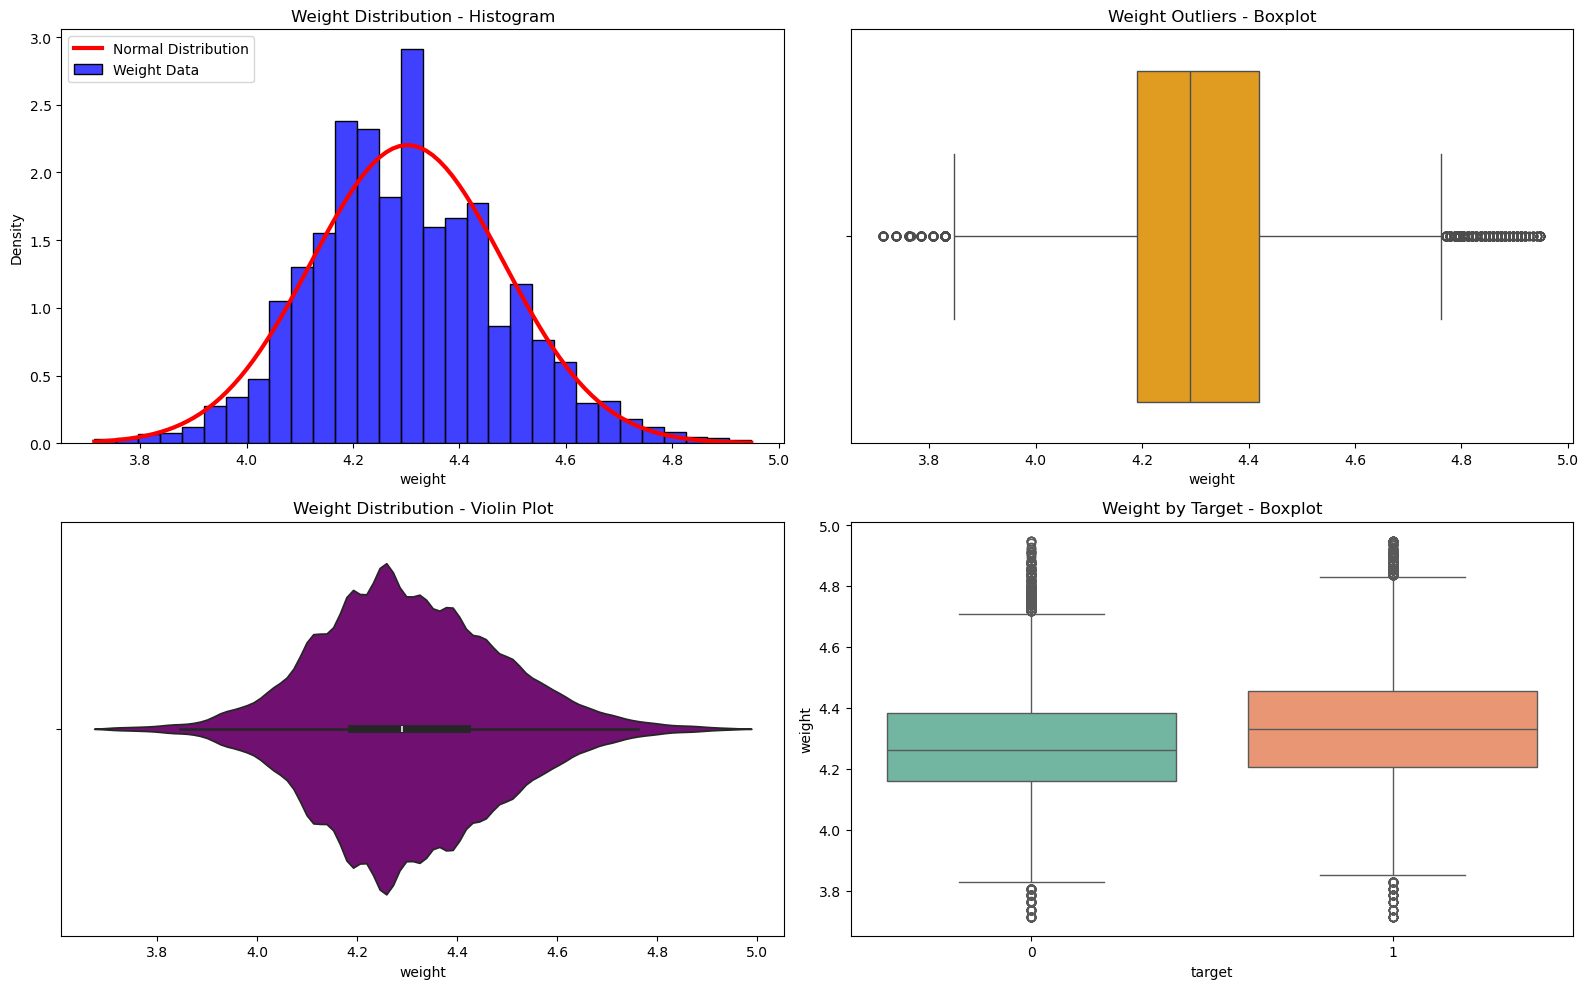

In [42]:
plot_numerical_feature(data, 'weight')

In [43]:
skew_kurtosis(data, 'weight')

Skewness: 0.2139611844278531, Kurtosis: 0.19599518866351184


##### `ap_hi`

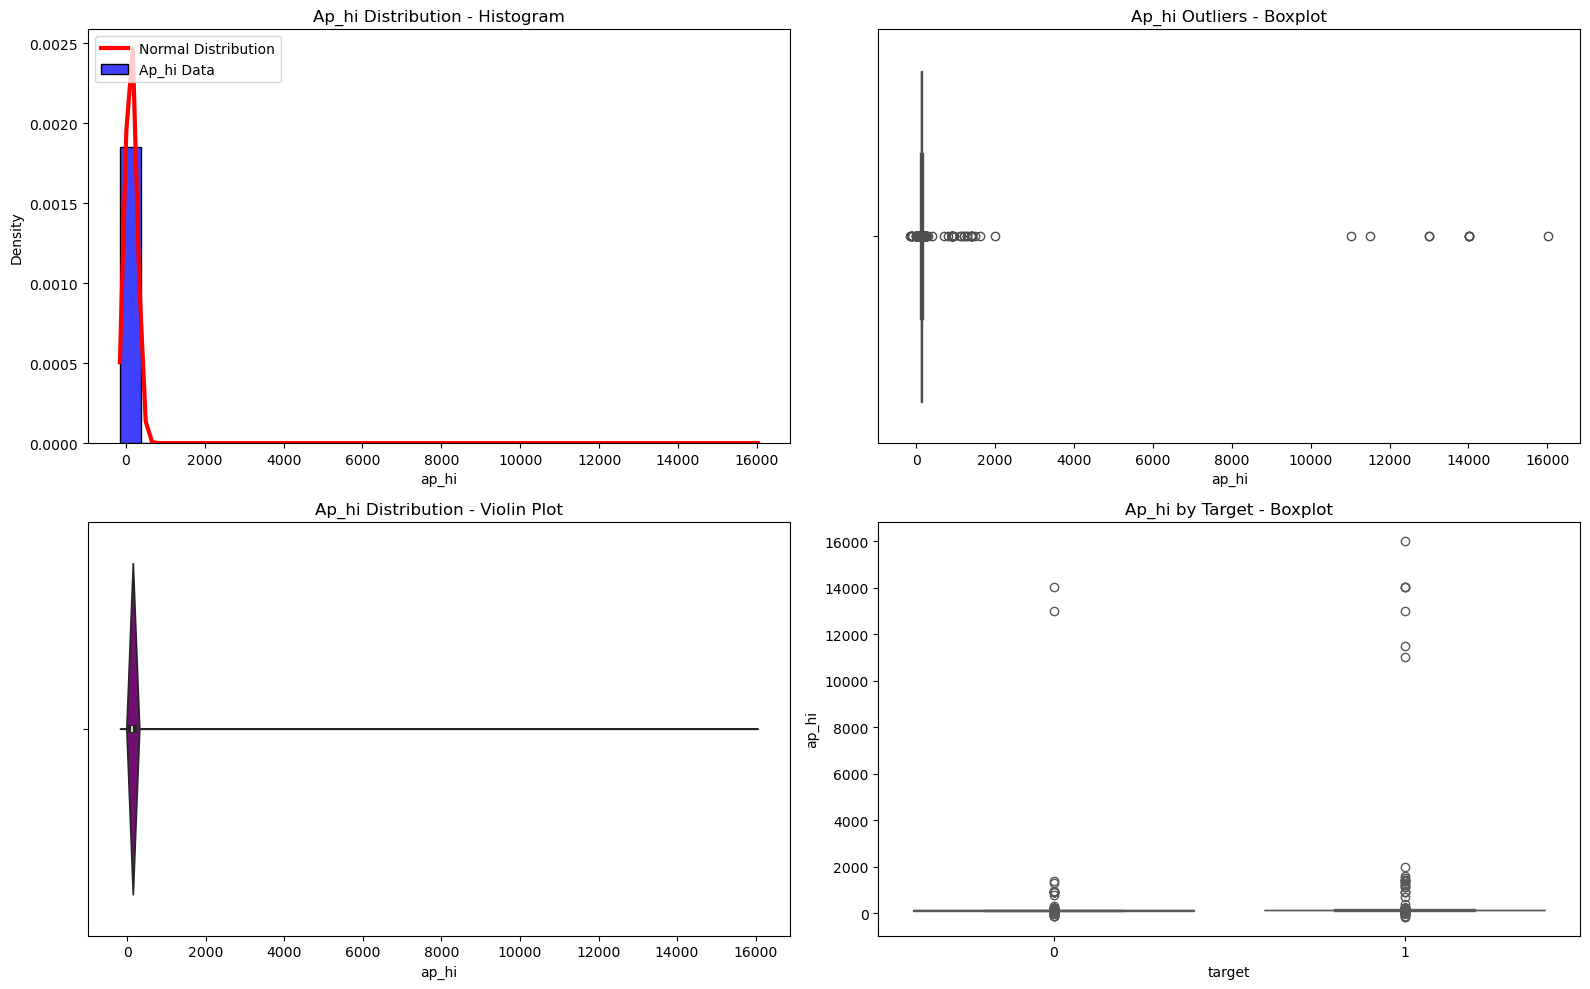

In [44]:
plot_numerical_feature(data, 'ap_hi')

In [45]:
skew_kurtosis(data, 'ap_hi')

Skewness: 85.1258876449779, Kurtosis: 7548.820844167734


In [46]:
print(data['ap_hi'].quantile([0.001, 0.01, 0.99, 0.999]))

0.001     12.0
0.010     90.0
0.990    180.0
0.999    220.0
Name: ap_hi, dtype: float64


In [47]:
data = data[(data['ap_hi'] >= 90) & (data['ap_hi'] <= 180)]
print(data.shape)

(69019, 12)


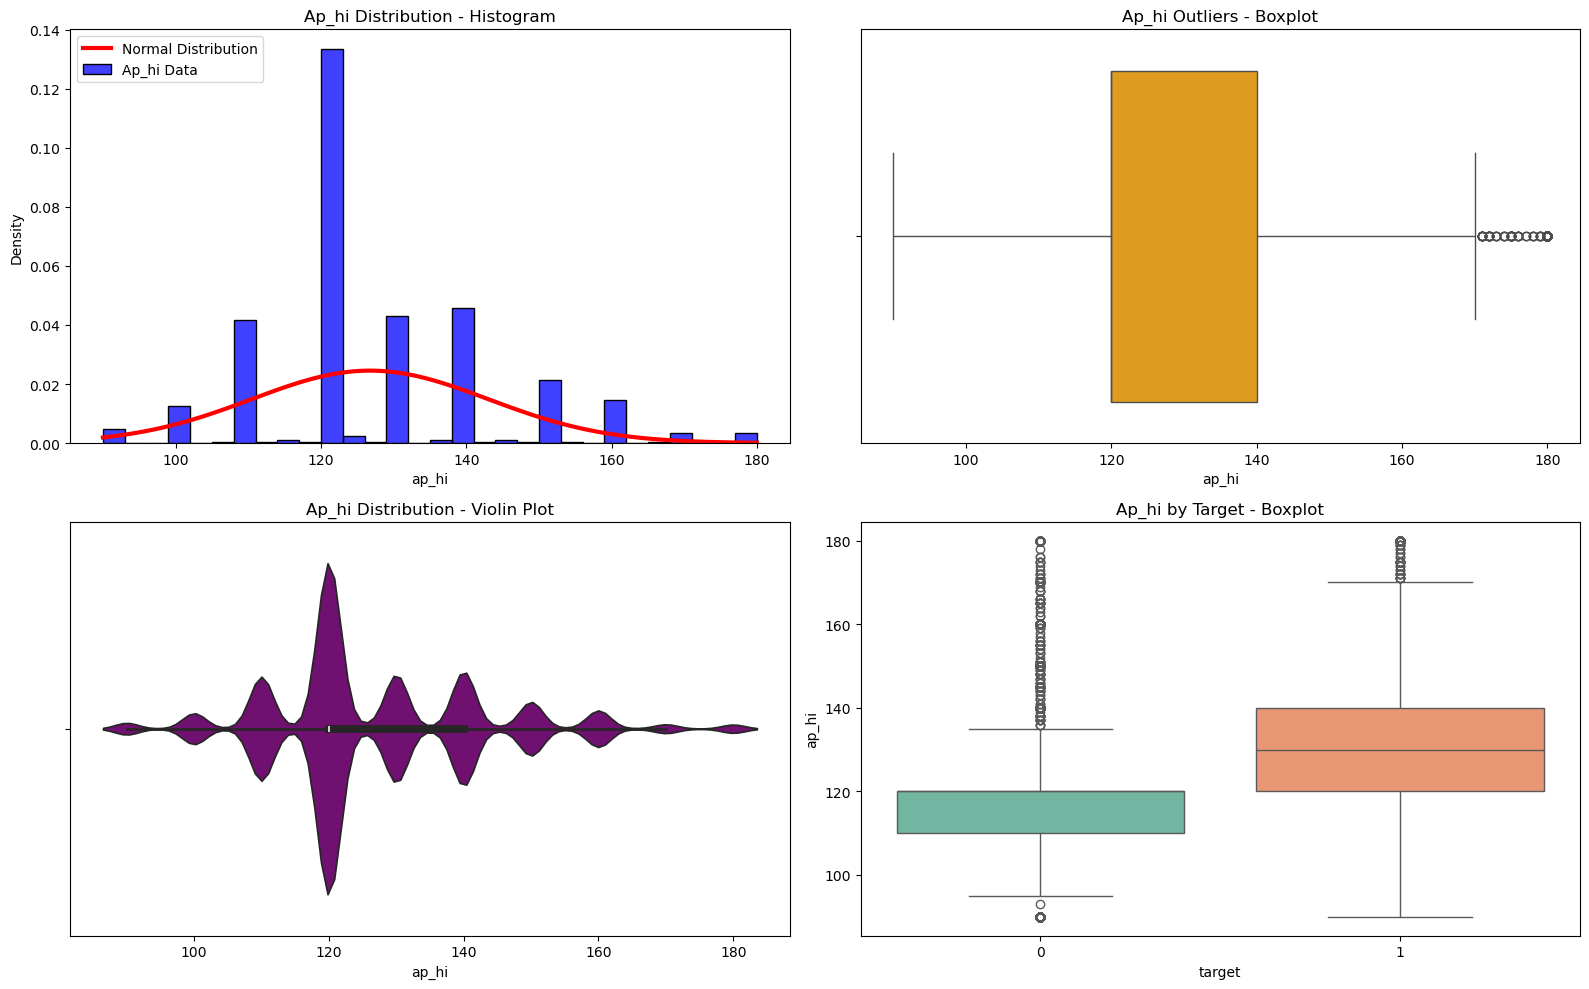

In [48]:
plot_numerical_feature(data, 'ap_hi')

In [49]:
skew_kurtosis(data, 'ap_hi')

Skewness: 0.730908118630687, Kurtosis: 0.6879041750891273


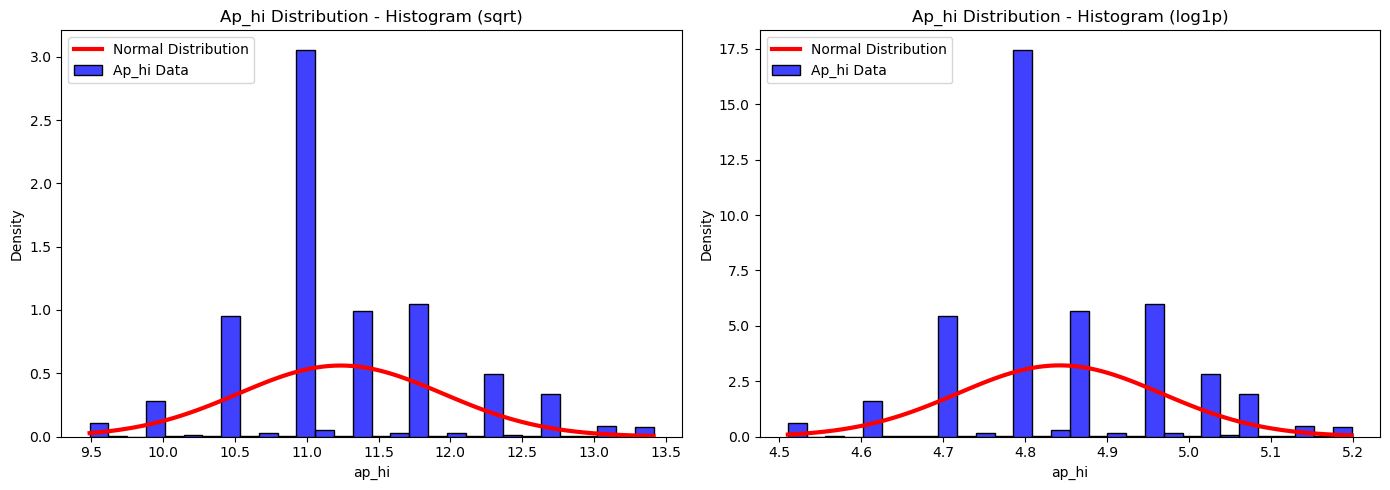

In [50]:
check_transform(data, 'ap_hi')

In [51]:
print(f'sqrt:\nSkewness: {skew(np.sqrt(data.ap_hi))}, Kurtosis: {kurtosis(np.sqrt(data.ap_hi))}\n')
print(f'log1p:\nSkewness: {skew(np.log1p(data.ap_hi))}, Kurtosis: {kurtosis(np.log1p(data.ap_hi))}\n')

ap_hi_boxcox, _ = boxcox(data['ap_hi'] + 1)
print(f'boxcox:\nSkewness: {skew(ap_hi_boxcox)}, Kurtosis: {kurtosis(ap_hi_boxcox)}')

sqrt:
Skewness: 0.5280674510594944, Kurtosis: 0.4666624276465199

log1p:
Skewness: 0.32220627367393434, Kurtosis: 0.3726708808373229

boxcox:
Skewness: -0.01288959046961856, Kurtosis: 0.4886082922055568


In [52]:
data['ap_hi'], _ = boxcox(data['ap_hi'] + 1)

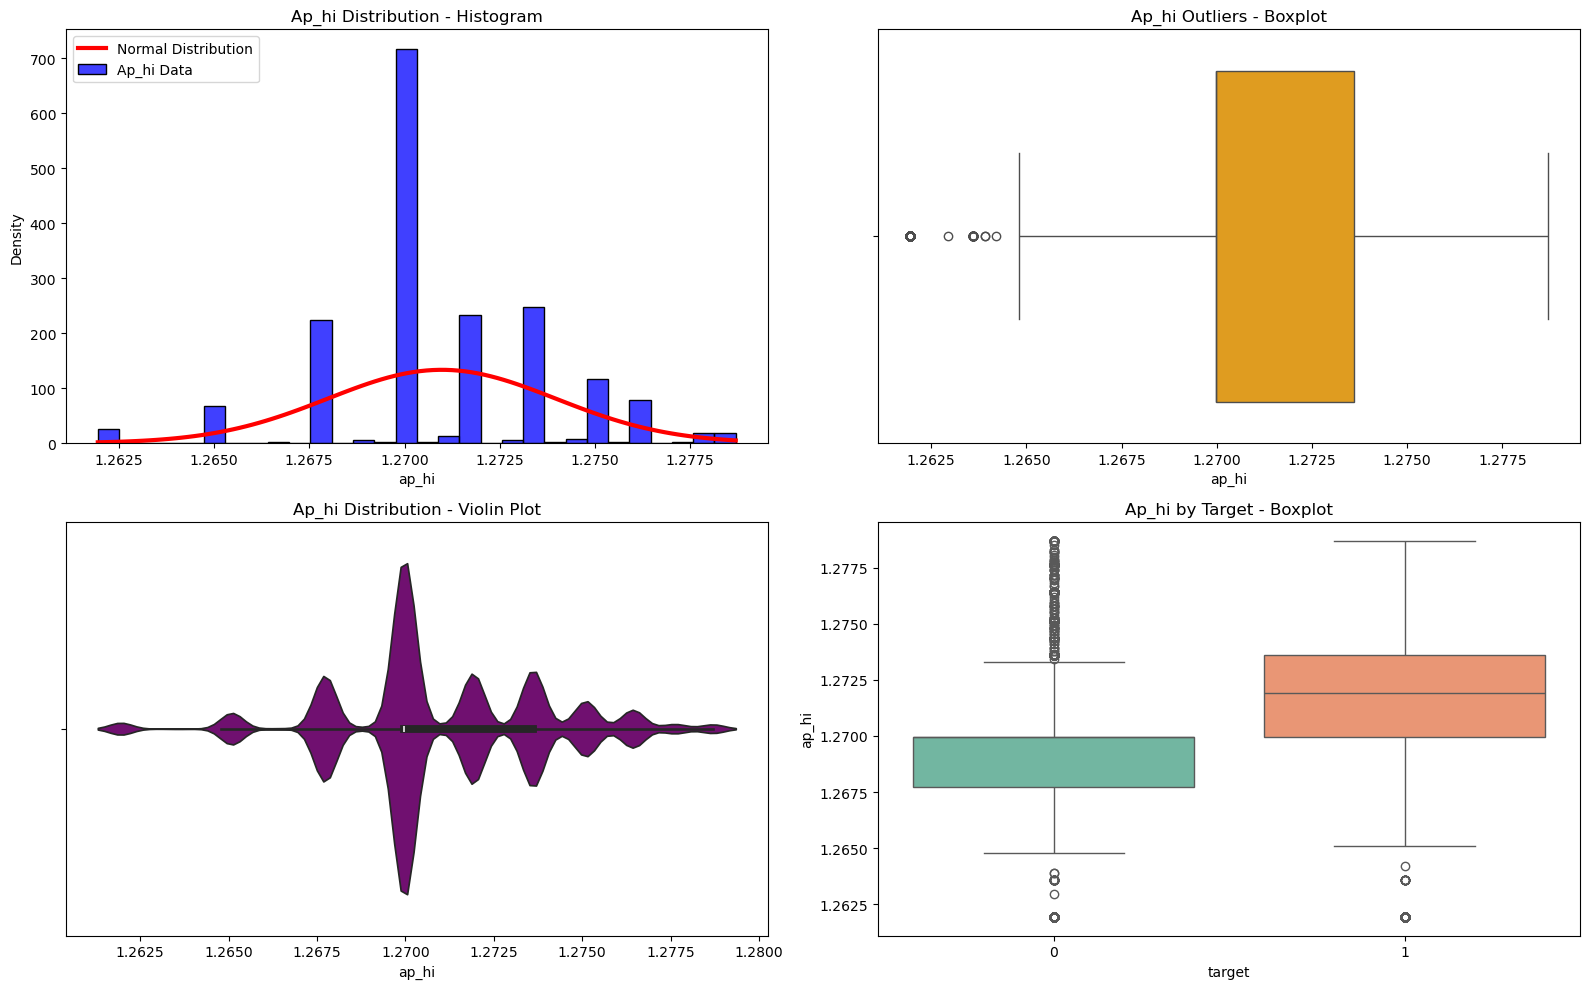

In [53]:
plot_numerical_feature(data, 'ap_hi')

In [54]:
skew_kurtosis(data, 'ap_hi')

Skewness: -0.01288959046961856, Kurtosis: 0.4886082922055568


##### `ap_lo`

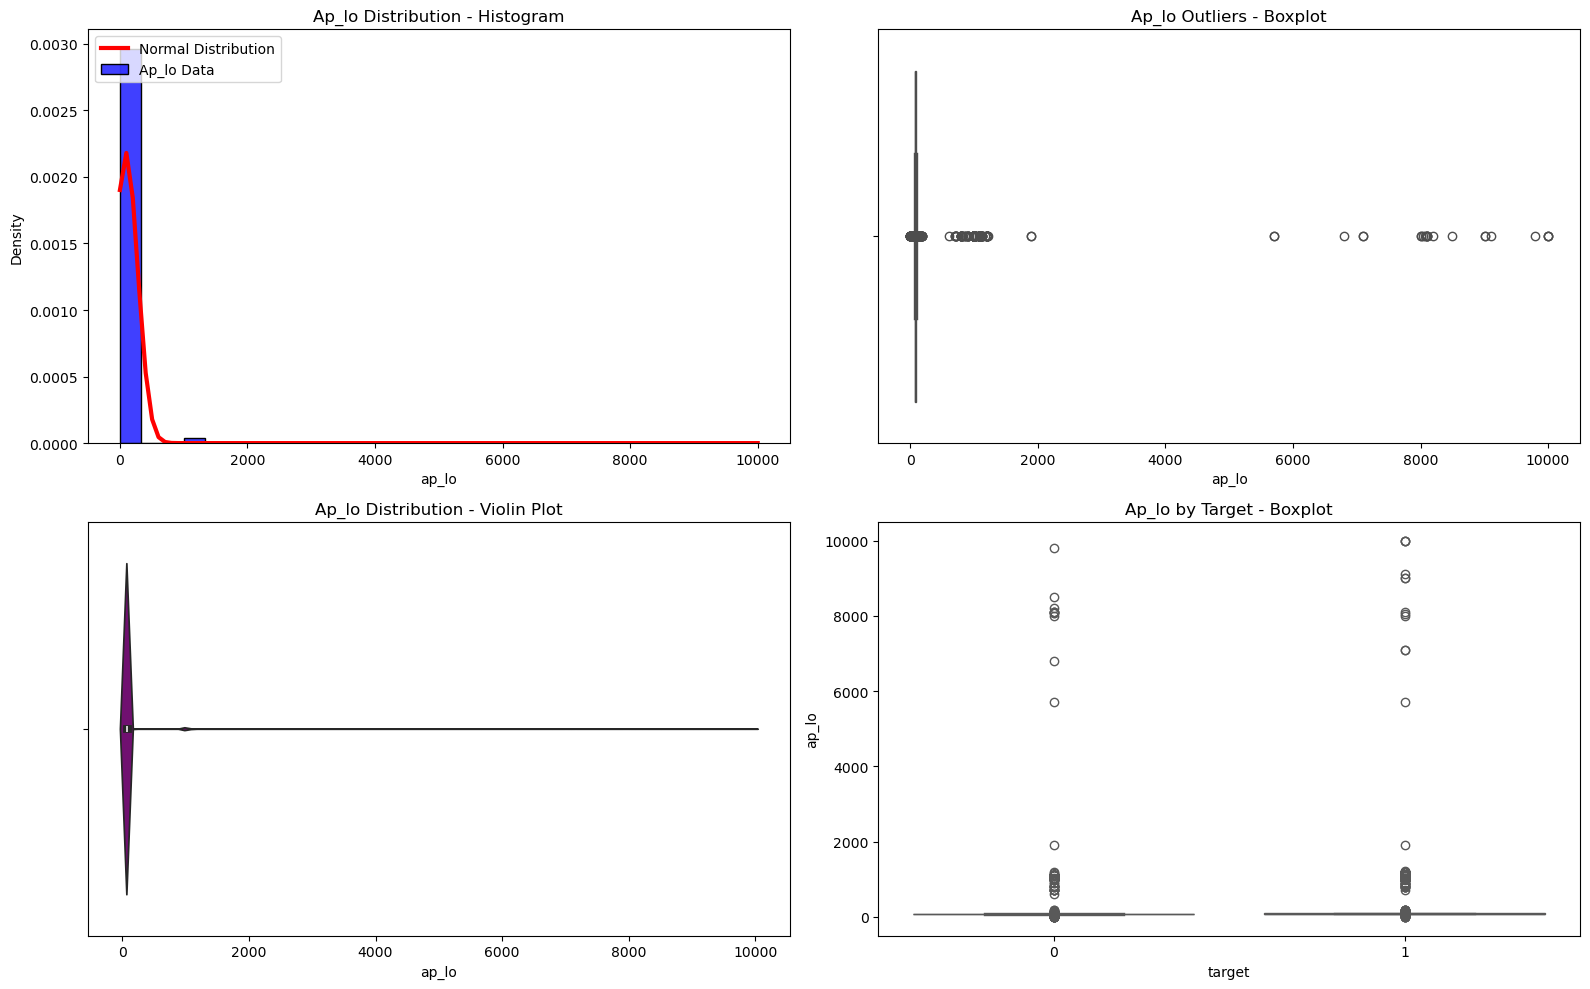

In [55]:
plot_numerical_feature(data, 'ap_lo')

In [56]:
skew_kurtosis(data, 'ap_lo')

Skewness: 32.431870665490315, Kurtosis: 1447.3225112180926


In [57]:
print(data['ap_lo'].quantile([0.001, 0.01, 0.99, 0.999]))

0.001      50.0
0.010      60.0
0.990    1000.0
0.999    1100.0
Name: ap_lo, dtype: float64


In [58]:
data = data[(data['ap_lo'] >= 40) & (data['ap_lo'] <= 120)]
print(data.shape)

(68026, 12)


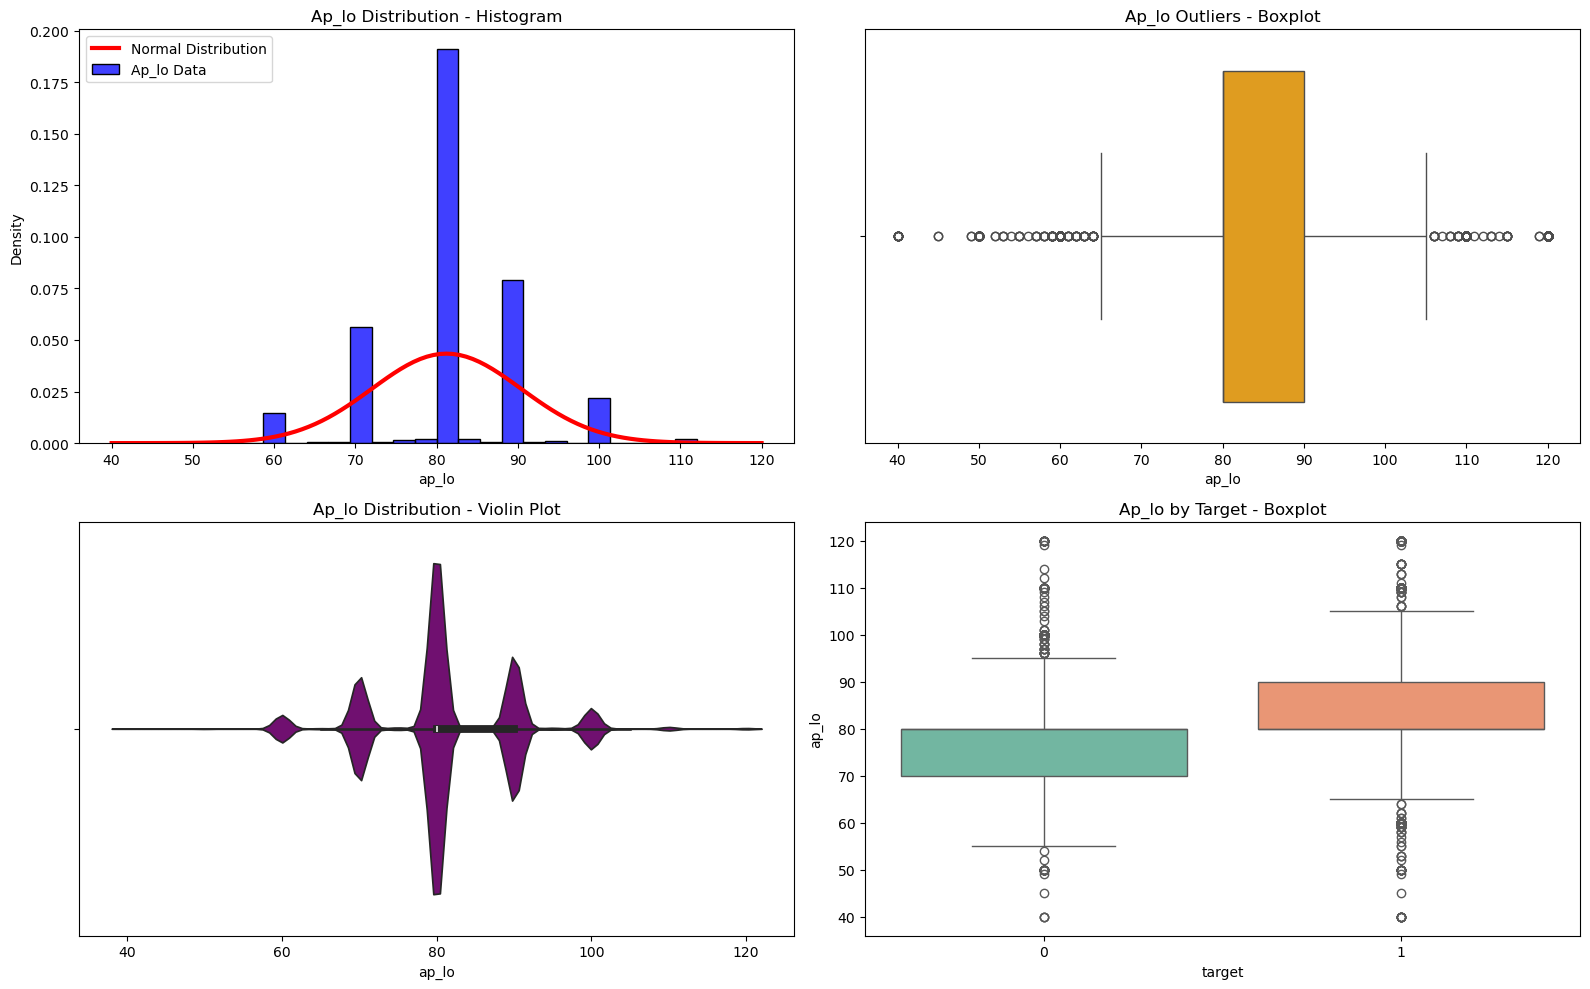

In [59]:
plot_numerical_feature(data, 'ap_lo')

In [60]:
skew_kurtosis(data, 'ap_lo')

Skewness: 0.18715896704051735, Kurtosis: 1.0034125921542705


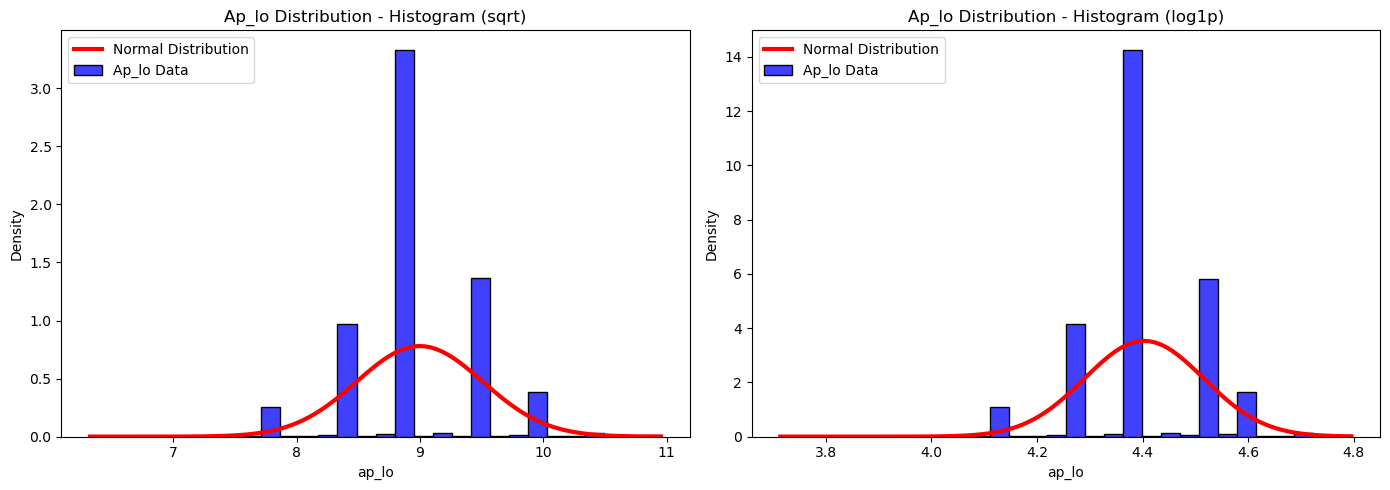

In [61]:
check_transform(data, 'ap_lo')

In [62]:
print(f'sqrt:\nSkewness: {skew(np.sqrt(data.ap_lo))}, Kurtosis: {kurtosis(np.sqrt(data.ap_lo))}\n')
print(f'log1p:\nSkewness: {skew(np.log1p(data.ap_lo))}, Kurtosis: {kurtosis(np.log1p(data.ap_lo))}\n')

ap_lo_boxcox, _ = boxcox(data['ap_lo'] + 1)
print(f'boxcox:\nSkewness: {skew(ap_lo_boxcox)}, Kurtosis: {kurtosis(ap_lo_boxcox)}')

sqrt:
Skewness: -0.06457779656627942, Kurtosis: 0.9581383139480146

log1p:
Skewness: -0.31479074320099465, Kurtosis: 1.1335519077038771

boxcox:
Skewness: 0.023685976636064834, Kurtosis: 0.9486444727891743


In [63]:
data['ap_lo'], _ = boxcox(data['ap_lo'] + 1)

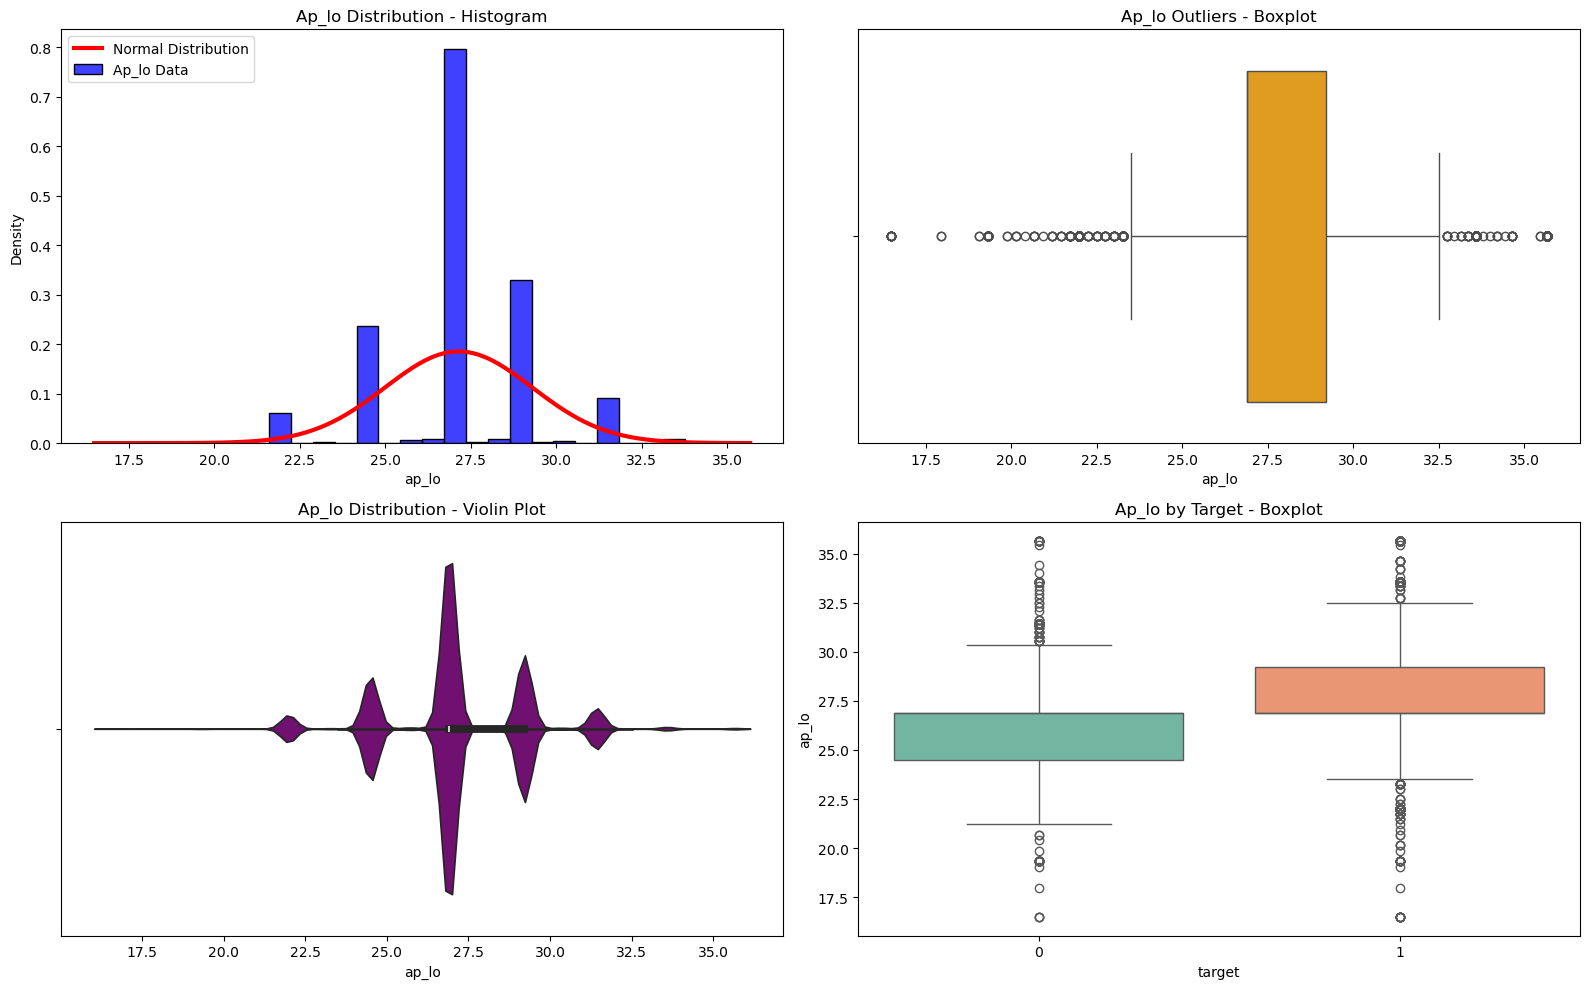

In [64]:
plot_numerical_feature(data, 'ap_lo')

In [65]:
skew_kurtosis(data, 'ap_lo')

Skewness: 0.023685976636064834, Kurtosis: 0.9486444727891743


#### `Processing Categorical Features`

In [66]:
def plot_categorical_feature(df, feature_name):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Categorical Analysis for {feature_name} with Target', fontsize=16)

    # 1. Count plot for binary target
    sns.countplot(data=df, x=feature_name, hue='target', ax=axes[0, 0])
    axes[0, 0].set_title('Count Plot by Target')
    
    # 2. Proportion plot with binary target
    sns.barplot(data=df, x=feature_name, y=df['target'].value_counts(normalize=True), ax=axes[0, 1])
    axes[0, 1].set_title('Proportion Plot by Target')
    
    # 3. Box plot for binary target
    sns.boxplot(data=df, x=feature_name, y='target', ax=axes[1, 0])
    axes[1, 0].set_title('Box Plot by Target')
    
    # 4. Violin plot for binary target
    sns.violinplot(data=df, x=feature_name, y='target', ax=axes[1, 1])
    axes[1, 1].set_title('Violin Plot by Target')
    
    plt.tight_layout()
    plt.show()


##### `gender`

In [67]:
data["gender"] = data["gender"] - 1
print(data["gender"].value_counts())

gender
0    44350
1    23676
Name: count, dtype: int64


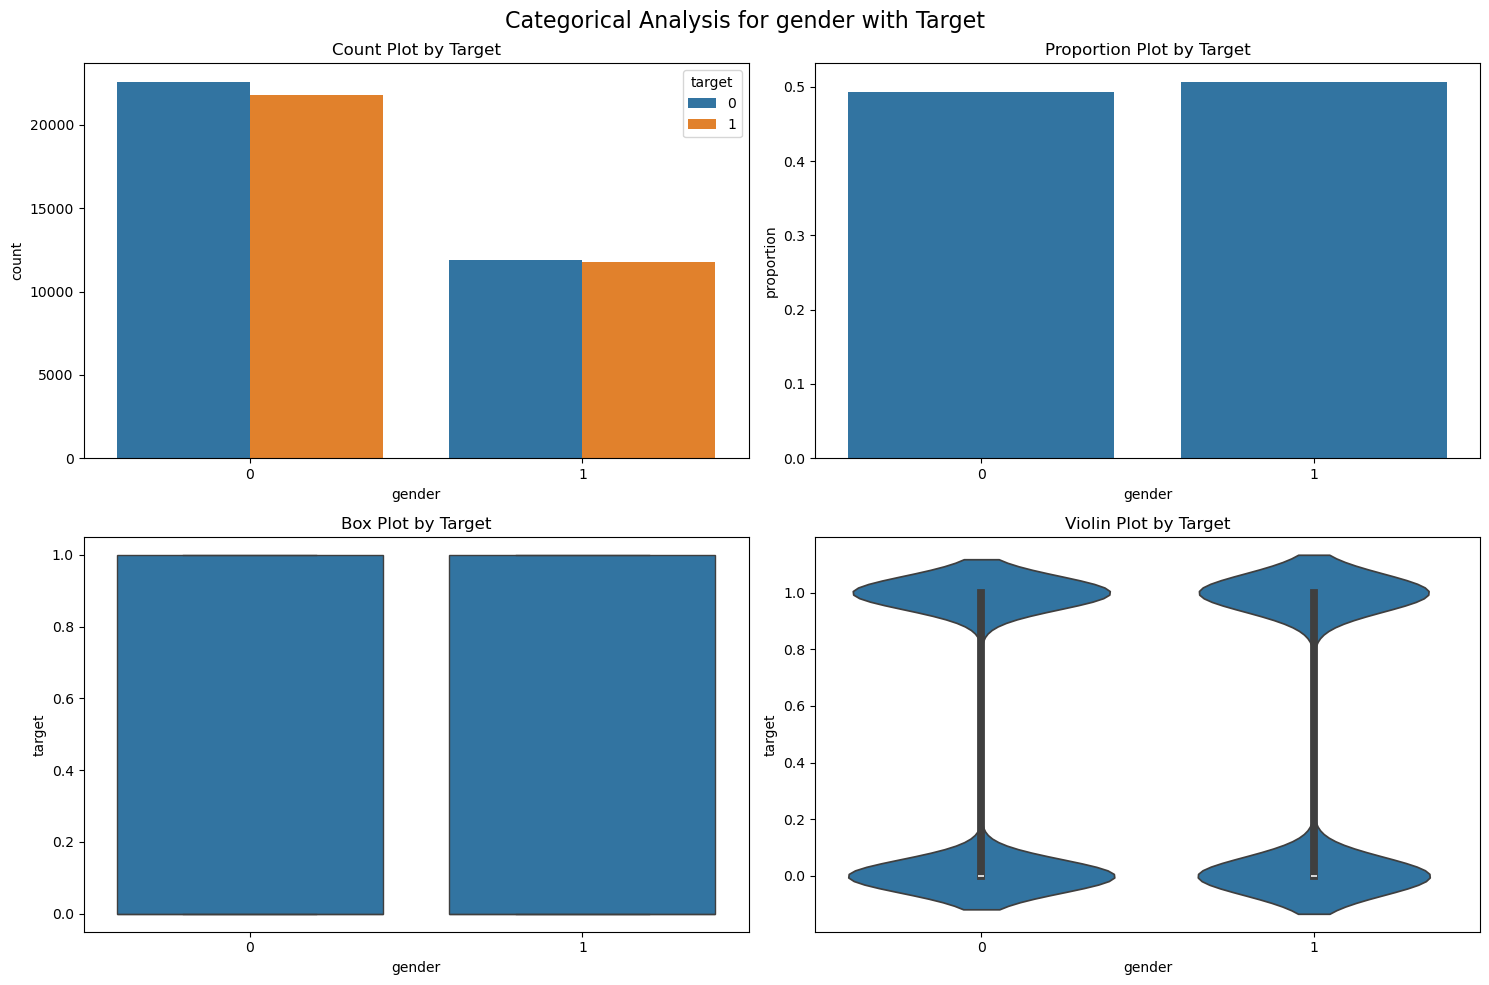

In [68]:
plot_categorical_feature(data, 'gender')

##### `cholesterol`

In [69]:
print(data["cholesterol"].value_counts())

cholesterol
1    51076
2     9174
3     7776
Name: count, dtype: int64


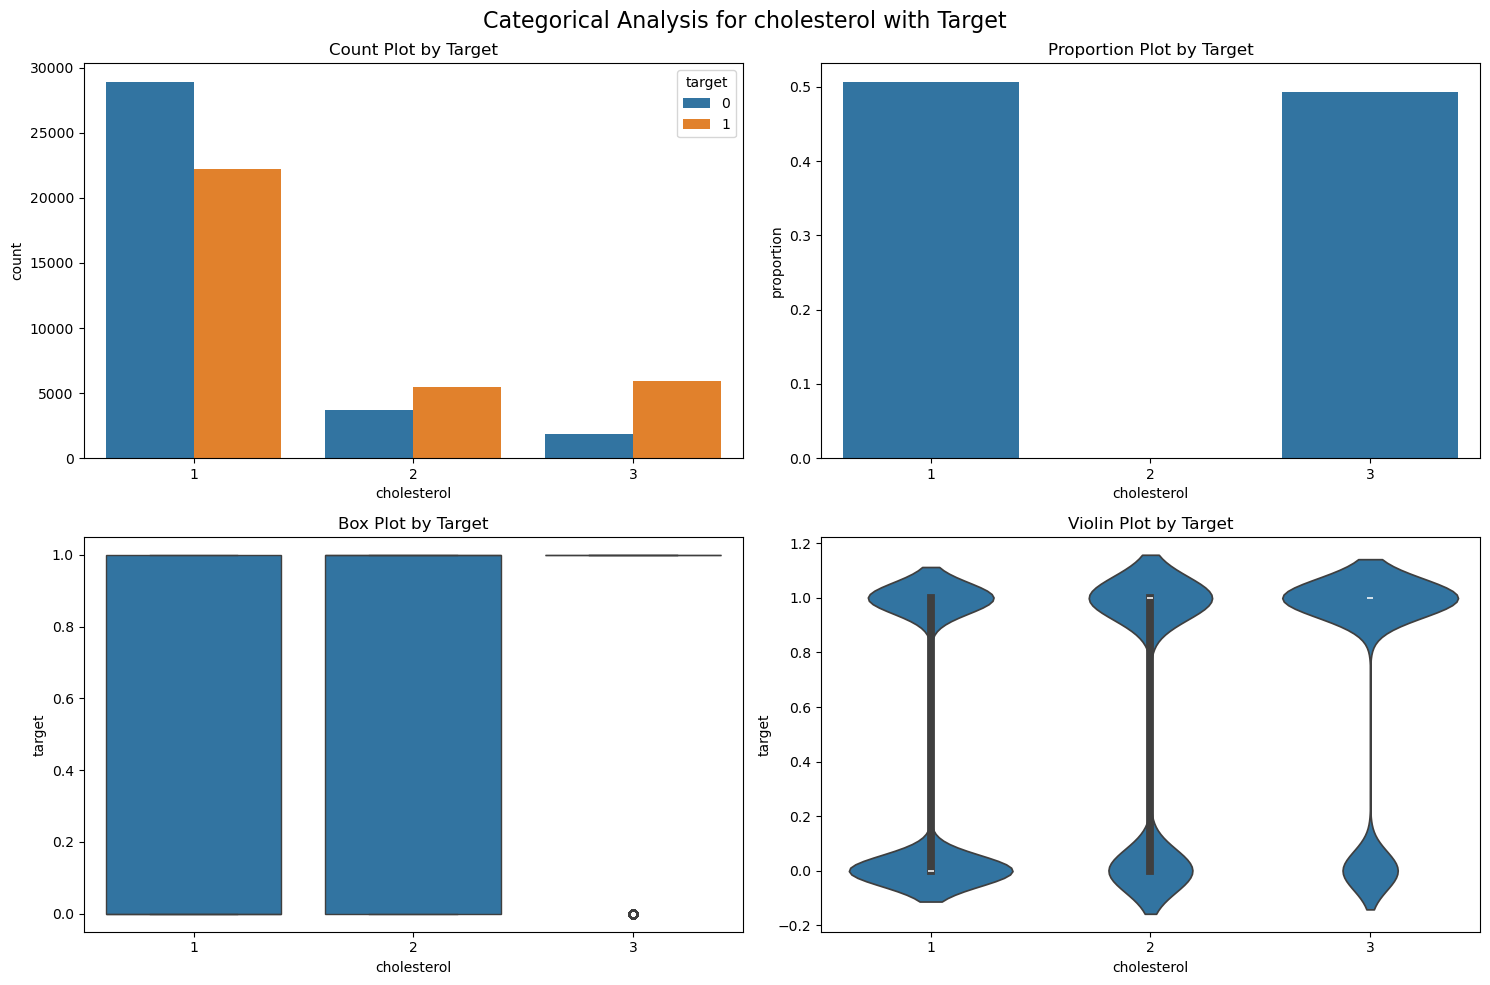

In [70]:
plot_categorical_feature(data, 'cholesterol')

In [71]:
data = pd.get_dummies(data, columns=['cholesterol'], drop_first=False)
data['cholesterol_1'] = data['cholesterol_1'].astype(int)
data['cholesterol_2'] = data['cholesterol_2'].astype(int)
data['cholesterol_3'] = data['cholesterol_3'].astype(int)

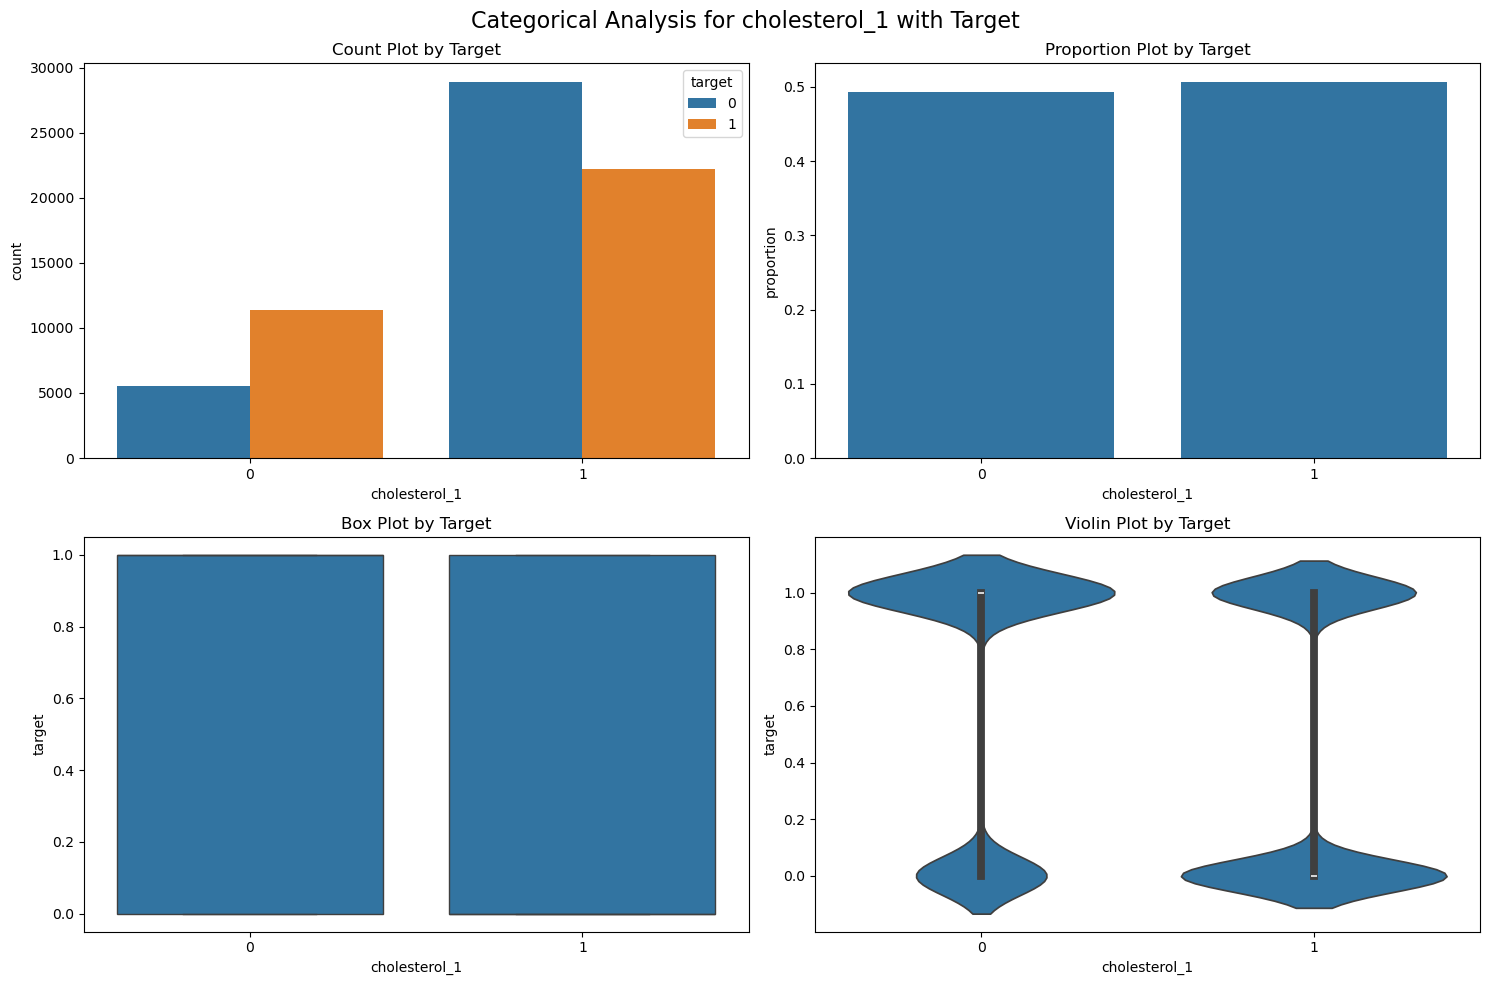

In [72]:
plot_categorical_feature(data, 'cholesterol_1')

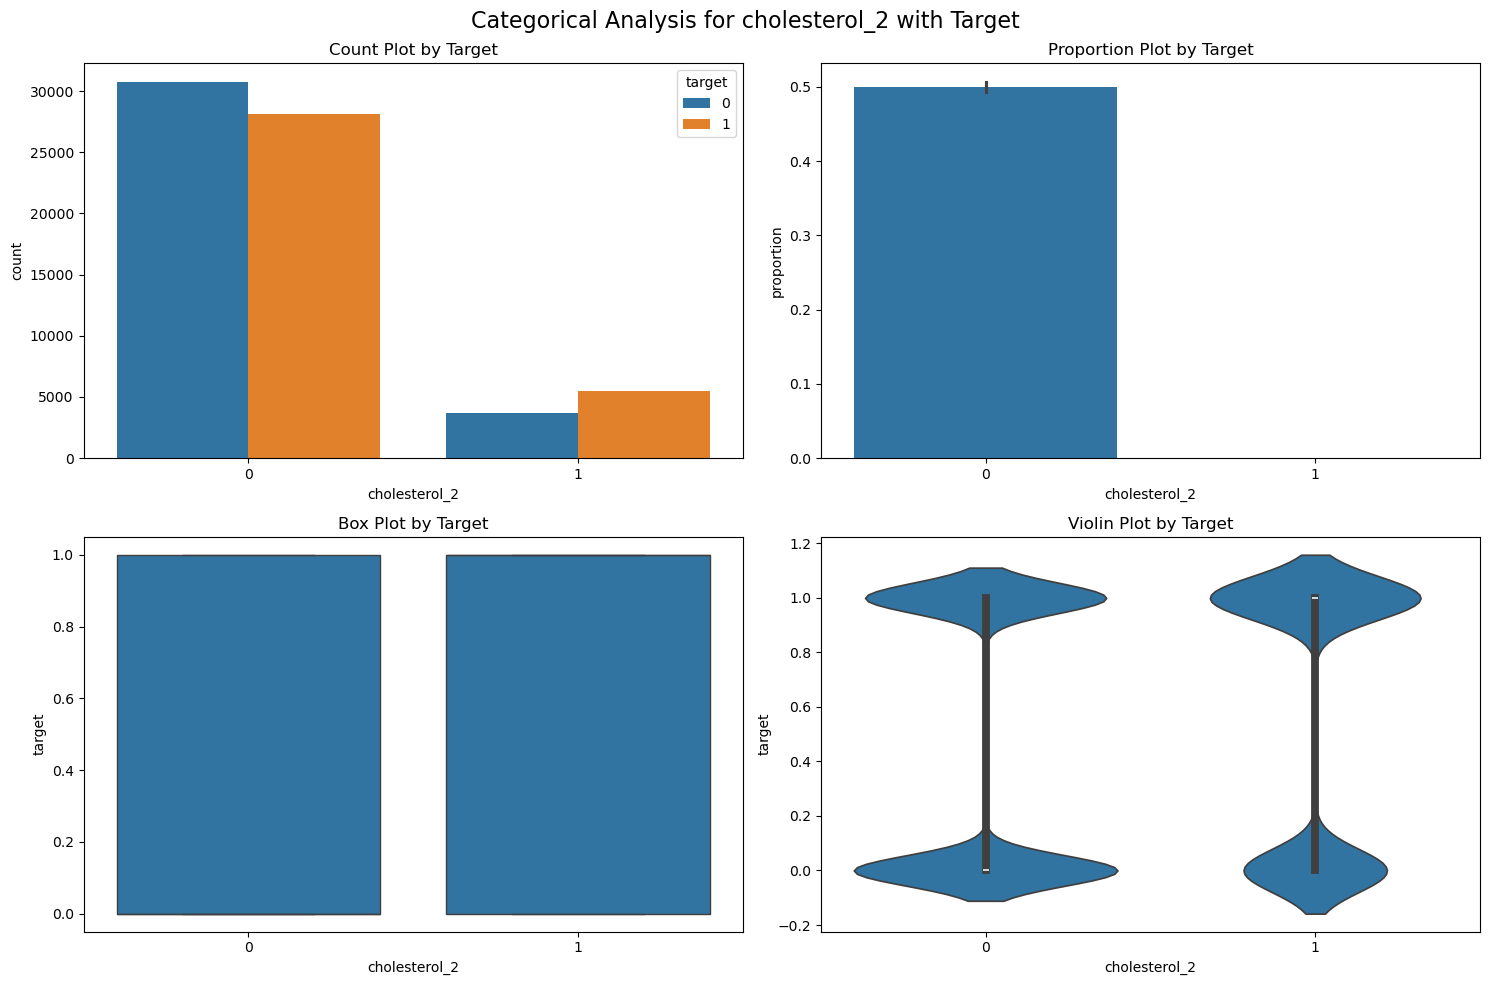

In [73]:
plot_categorical_feature(data, 'cholesterol_2')

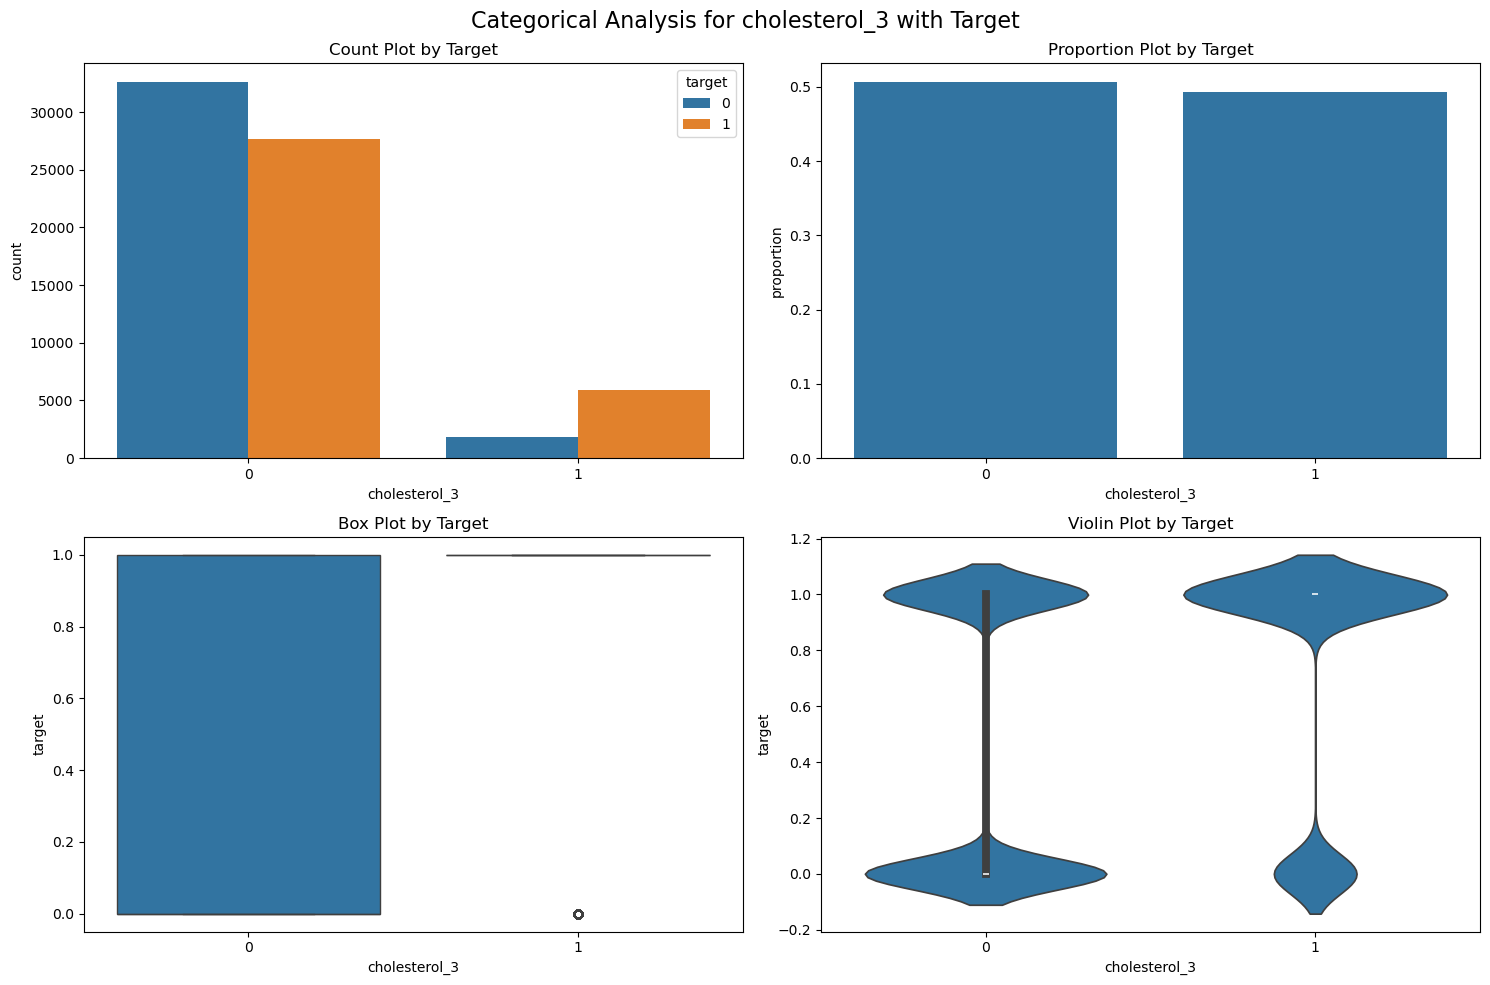

In [74]:
plot_categorical_feature(data, 'cholesterol_3')

##### `gluc`

In [75]:
print(data["gluc"].value_counts())

gluc
1    57882
3     5161
2     4983
Name: count, dtype: int64


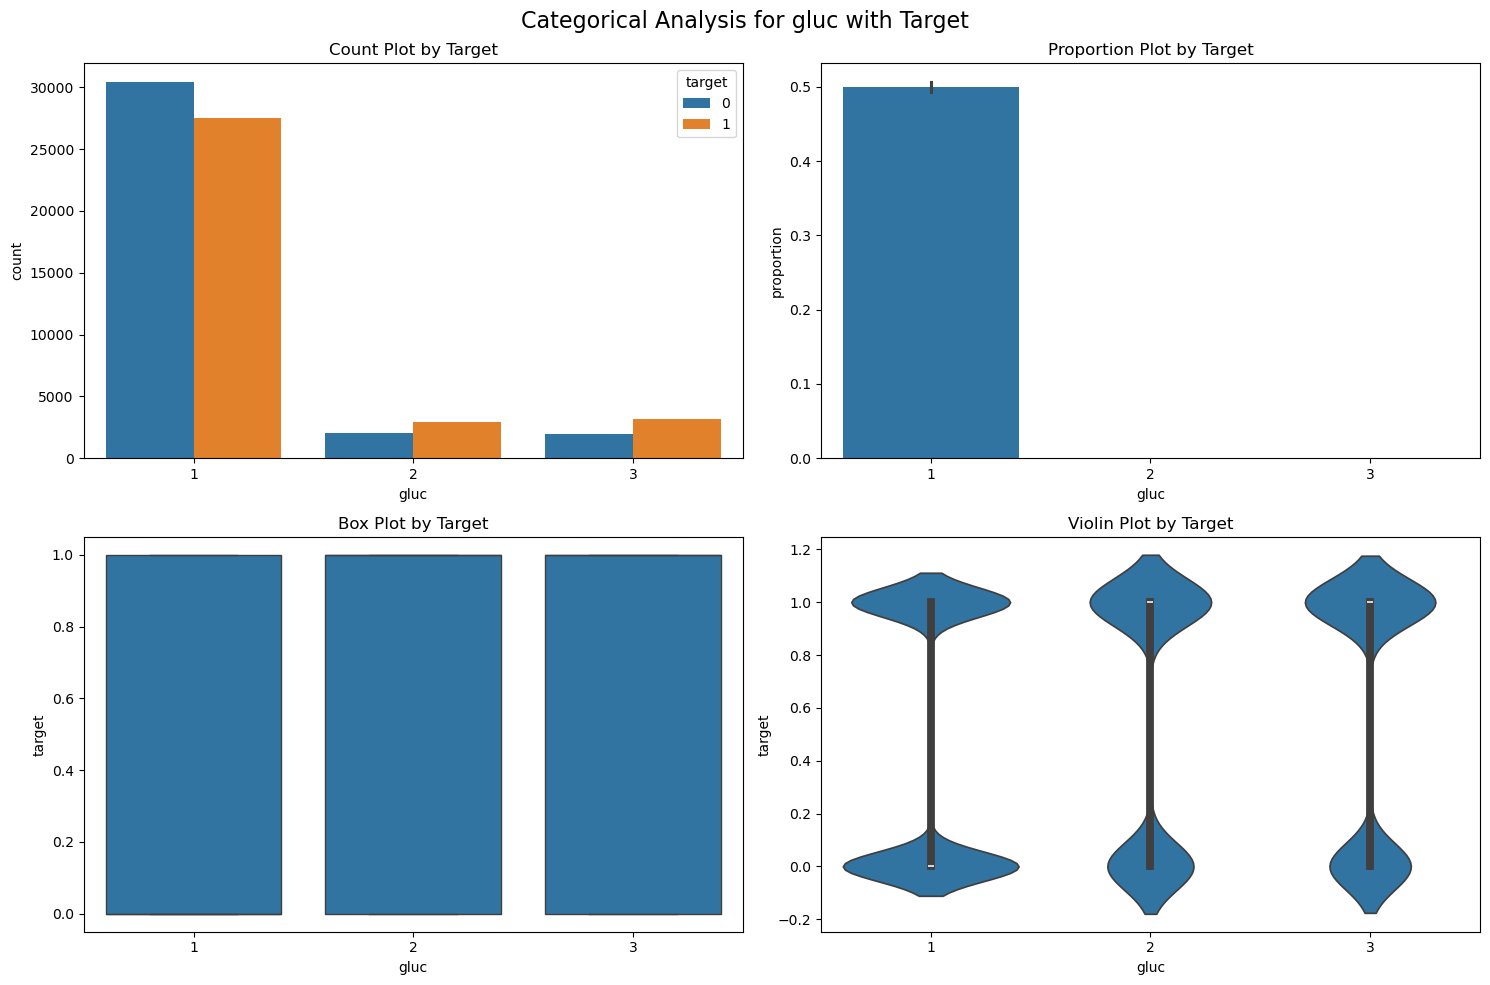

In [76]:
plot_categorical_feature(data, 'gluc')

In [77]:
data = pd.get_dummies(data, columns=['gluc'], drop_first=False)
data['gluc_1'] = data['gluc_1'].astype(int)
data['gluc_2'] = data['gluc_2'].astype(int)
data['gluc_3'] = data['gluc_3'].astype(int)

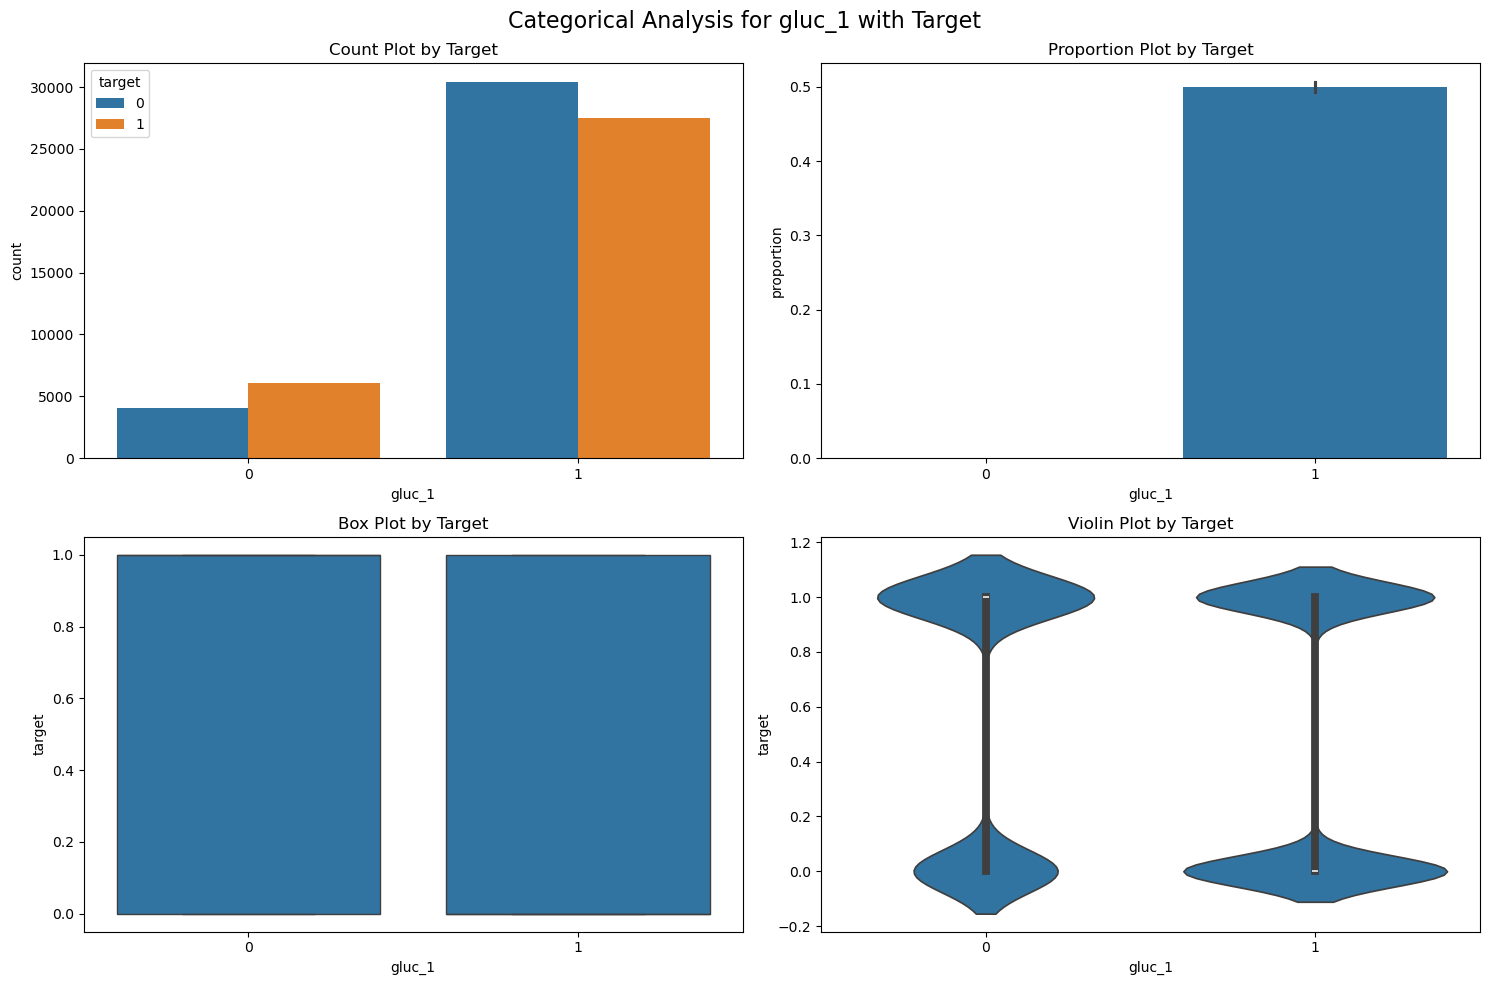

In [78]:
plot_categorical_feature(data, 'gluc_1')

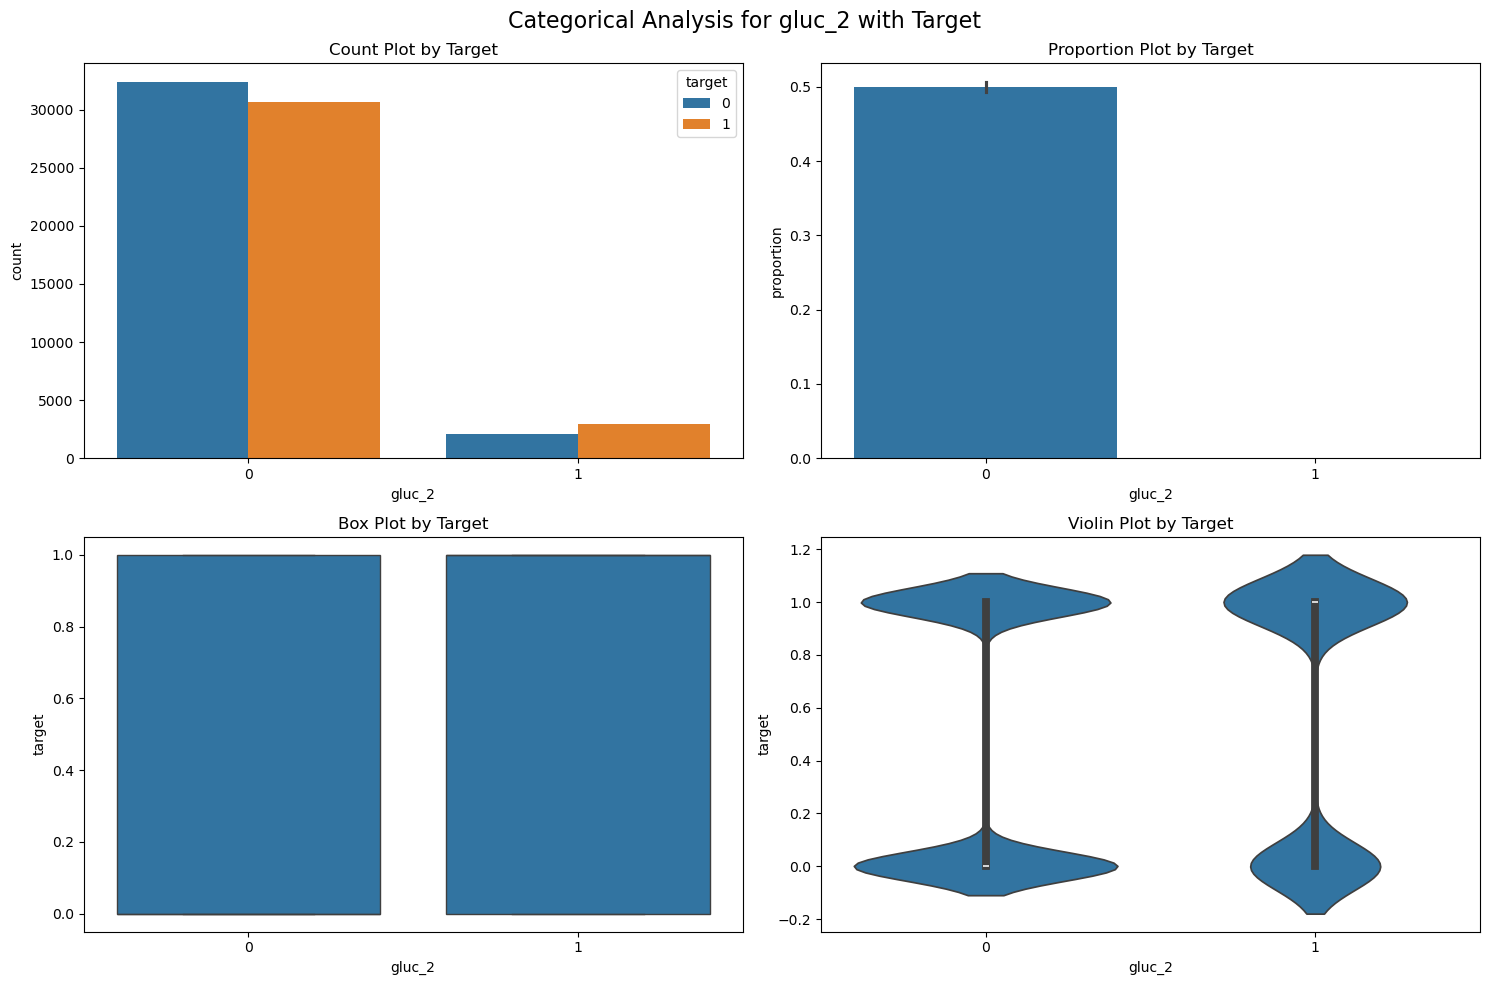

In [79]:
plot_categorical_feature(data, 'gluc_2')

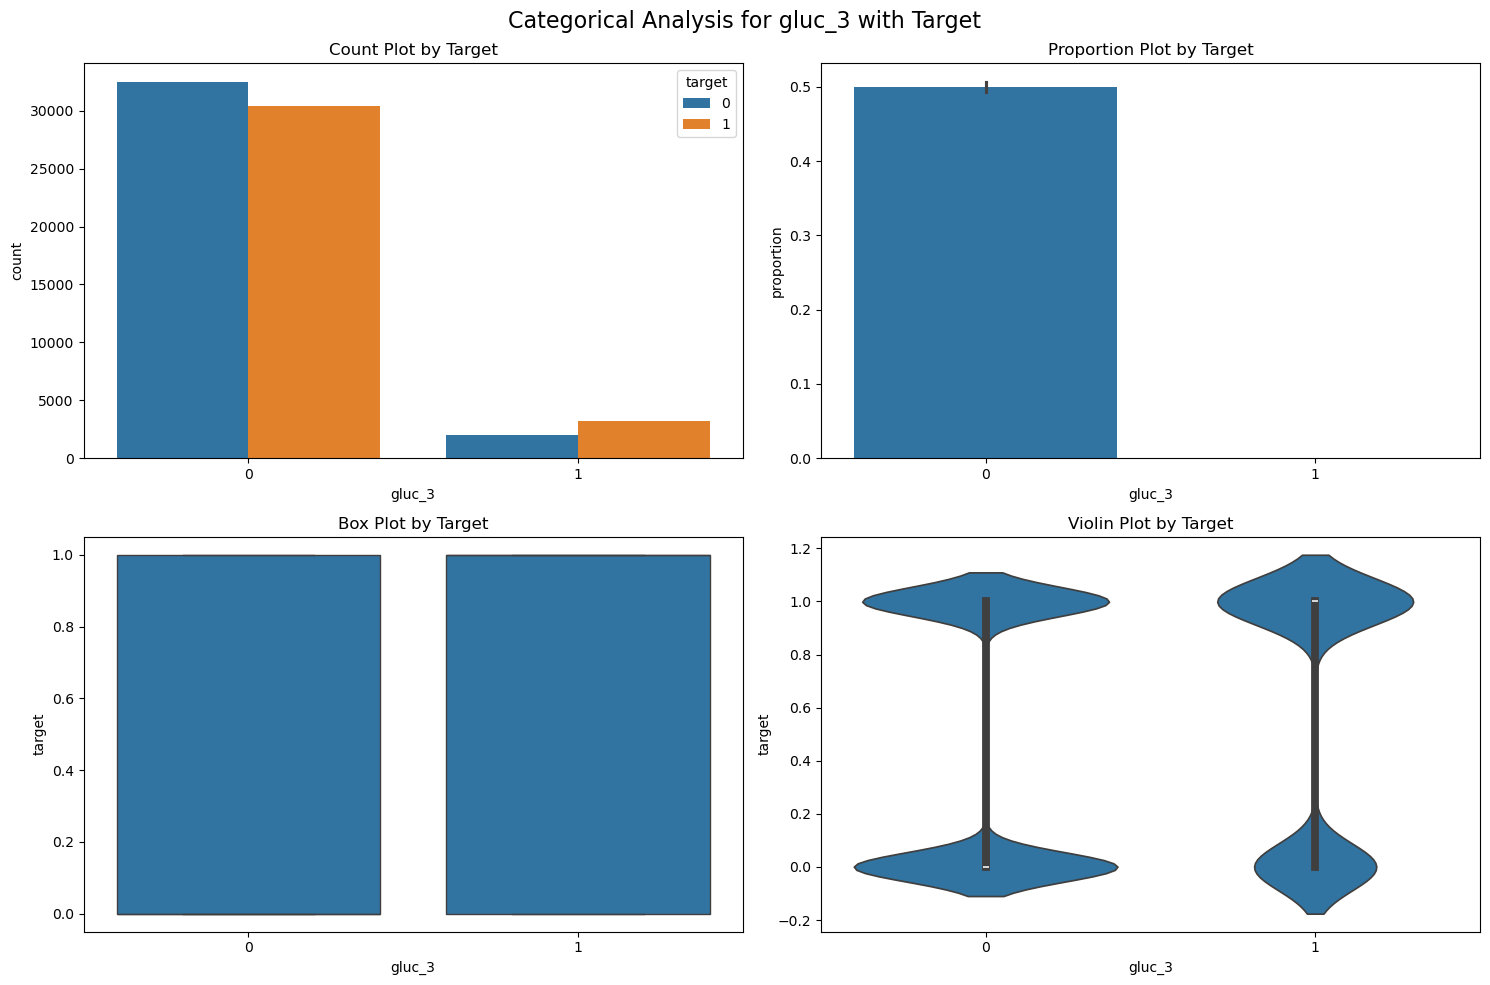

In [80]:
plot_categorical_feature(data, 'gluc_3')

##### `smoke`

In [81]:
print(data["smoke"].value_counts())

smoke
0    62065
1     5961
Name: count, dtype: int64


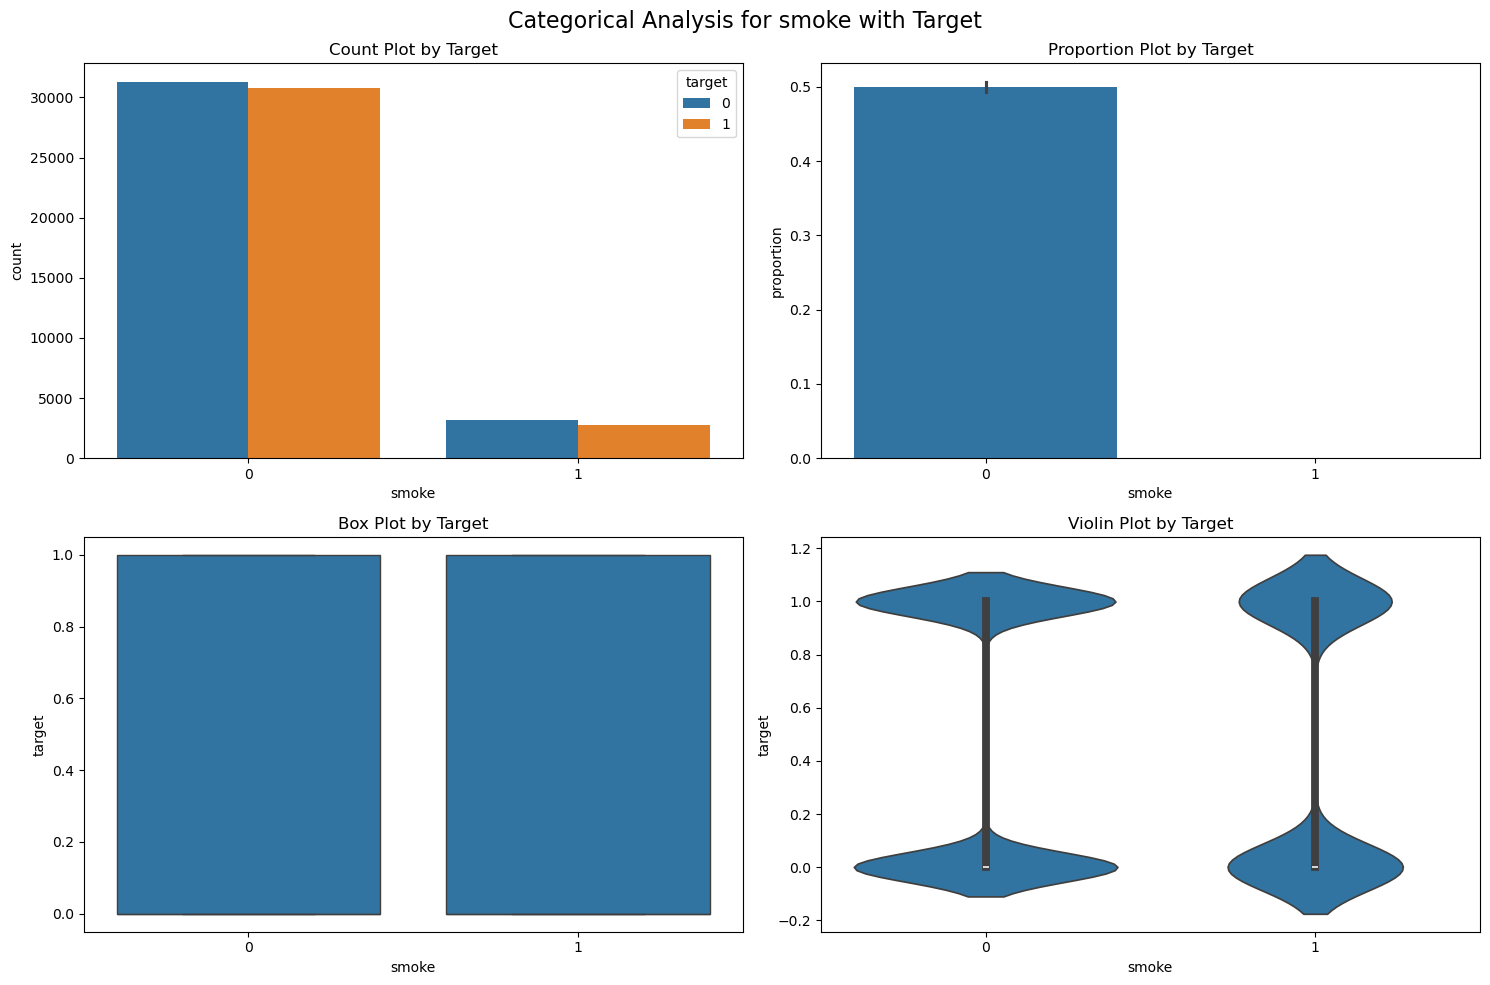

In [82]:
plot_categorical_feature(data, 'smoke')

##### `alco`

In [83]:
print(data["alco"].value_counts())

alco
0    64423
1     3603
Name: count, dtype: int64


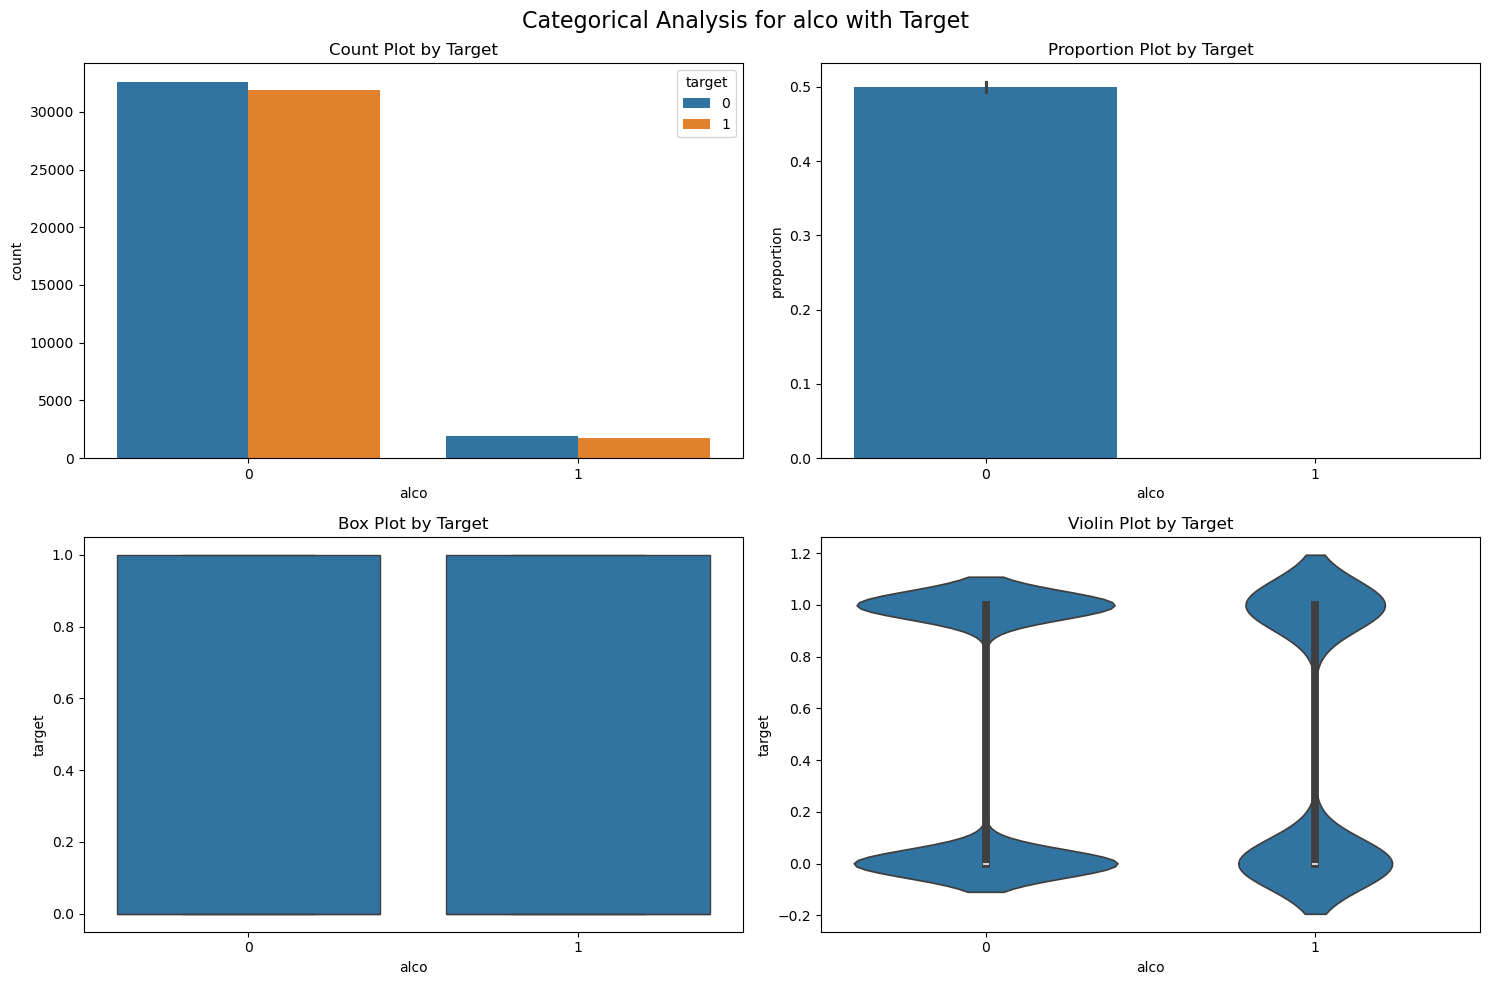

In [84]:
plot_categorical_feature(data, 'alco')

##### `active`

In [85]:
print(data["active"].value_counts())

active
1    54665
0    13361
Name: count, dtype: int64


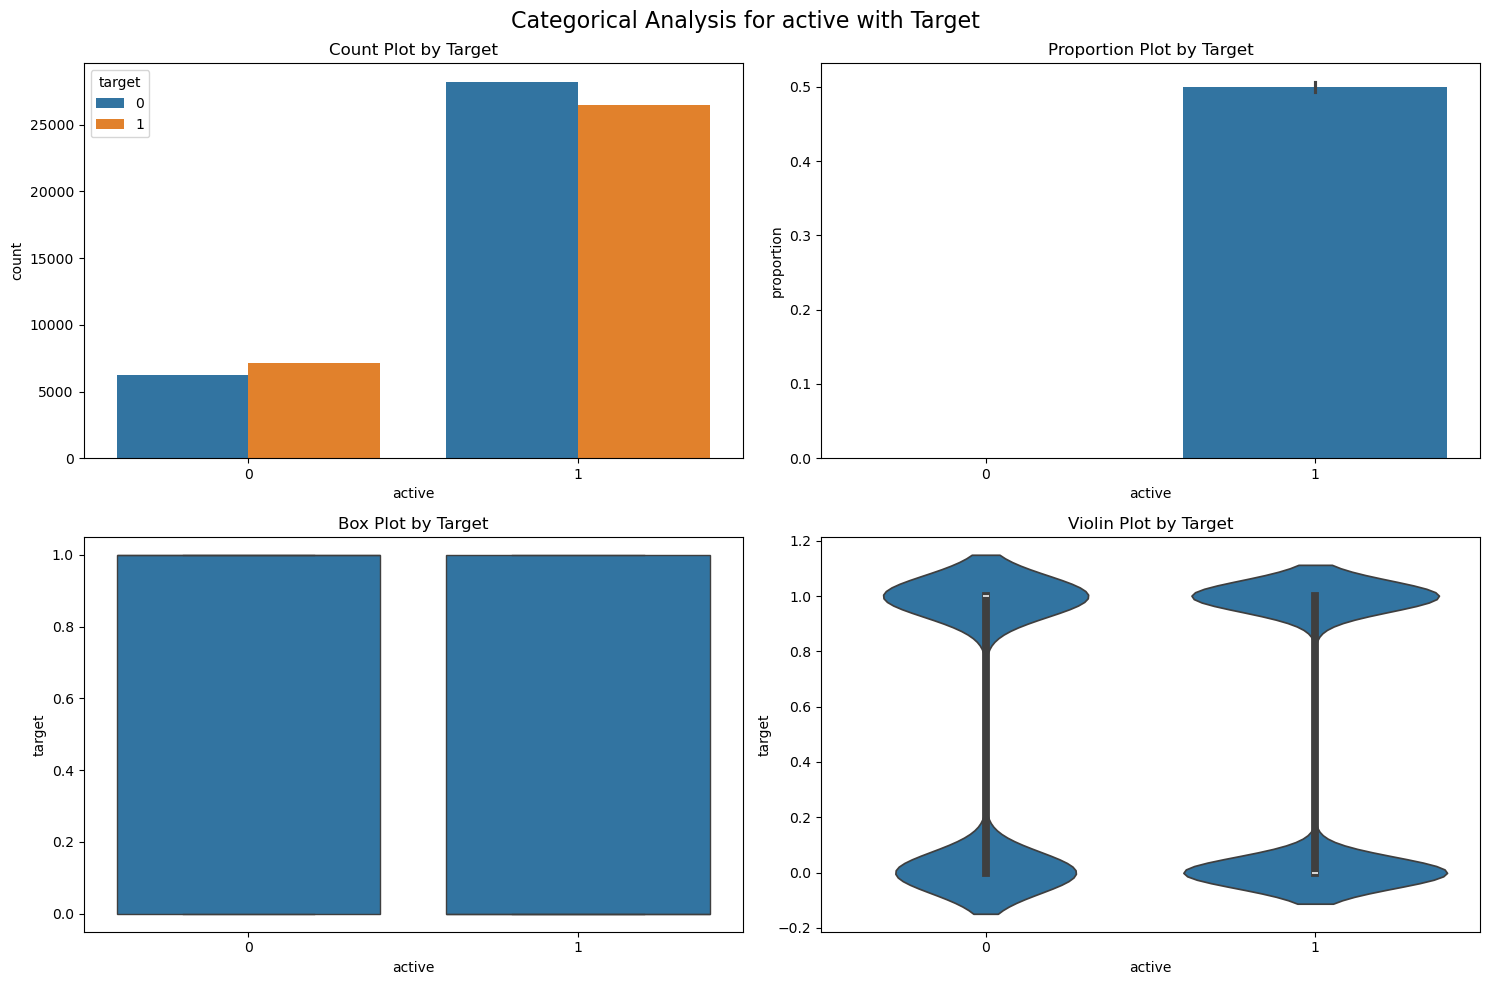

In [86]:
plot_categorical_feature(data, 'active')

### `Split Dataset (Train, Dev, Test)`

In [87]:
X = data.drop(columns="target", axis=1)
y = data["target"]

In [88]:
X.sample(5)

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,
70291,54,0,163,4.189655,1.269970,26.904162,0,0,1,1,0,0,1,0,0
96296,56,0,167,4.442651,1.278698,29.209346,0,1,1,1,0,0,1,0,0
79403,41,0,160,4.025352,1.267723,24.502983,0,0,0,0,0,1,1,0,0
89204,47,1,174,4.584967,1.274074,29.209346,1,1,1,1,0,0,1,0,0
28816,58,0,153,4.276666,1.269970,26.904162,0,0,0,1,0,0,1,0,0


In [89]:
print(f"Shape of X {X.shape} and Y {y.shape}")

Shape of X (68026, 15) and Y (68026,)


In [90]:
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.10, random_state=2)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.1111, random_state=2)

In [91]:
print(f"Training set size: {X_train.shape}")
print(f"Dev set size: {X_dev.shape}")
print(f"Test set size: {X_test.shape}")

print("\nTotal examples")
print(X_train.shape[0] + X_dev.shape[0] + X_test.shape[0])

Training set size: (54421, 15)
Dev set size: (6802, 15)
Test set size: (6803, 15)

Total examples
68026


In [92]:
print("y_train value Counts")
print(y_train.value_counts())

print("\ny_dev value Counts")
print(y_dev.value_counts())

print("\ny_test value Counts")
print(y_test.value_counts())

print("\nTotal examples")
print(y_train.shape[0] + y_dev.shape[0] + y_test.shape[0])

y_train value Counts
target
0    27649
1    26772
Name: count, dtype: int64

y_dev value Counts
target
0    3411
1    3391
Name: count, dtype: int64

y_test value Counts
target
1    3408
0    3395
Name: count, dtype: int64

Total examples
68026


### `Scaling Numerical Features`

In [93]:
numerical_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
numerical_features

['age', 'height', 'weight', 'ap_hi', 'ap_lo']

In [94]:
scaler = StandardScaler()

# Scale training data (fit and transform)
X_train_scaled = X_train.copy()
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])

In [95]:
# Scale dev and test data (transform only)
X_dev_scaled = X_dev.copy()
X_dev_scaled[numerical_features] = scaler.transform(X_dev[numerical_features])

X_test_scaled = X_test.copy()
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

In [96]:
# Verify scaling
print("X_train_scaled")
print(X_train_scaled.head())

print("\n\n X_dev_scaled")
print(X_dev_scaled.head())

print("\n\n X_test_scaled")
print(X_test_scaled.head())

X_train_scaled
            age  gender    height    weight     ap_hi     ap_lo  smoke  alco  \
id                                                                             
93812  1.206566       0 -0.824713 -1.329932 -1.975119 -2.402138      0     0   
96130 -0.415951       1  0.845438  0.449651  0.334505  0.957168      0     0   
82566  0.026554       0 -1.595552 -0.210791 -1.975119  0.957168      0     0   
30620 -1.743465       1  0.973911 -0.210791 -1.082958 -0.115079      0     0   
96914  0.911563       0 -0.567767 -0.057064 -0.322441 -0.115079      0     0   

       active  cholesterol_1  cholesterol_2  cholesterol_3  gluc_1  gluc_2  \
id                                                                           
93812       1              0              1              0       1       0   
96130       0              1              0              0       1       0   
82566       1              1              0              0       1       0   
30620       1              1      

In [97]:
# Verify scaling
print("X_train_scaled")
print(X_train_scaled.isnull().sum())

print("\n\n X_dev_scaled")
print(X_dev_scaled.isnull().sum())

print("\n\n X_test_scaled")
print(X_test_scaled.isnull().sum())

X_train_scaled
age              0
gender           0
height           0
weight           0
ap_hi            0
ap_lo            0
smoke            0
alco             0
active           0
cholesterol_1    0
cholesterol_2    0
cholesterol_3    0
gluc_1           0
gluc_2           0
gluc_3           0
dtype: int64


 X_dev_scaled
age              0
gender           0
height           0
weight           0
ap_hi            0
ap_lo            0
smoke            0
alco             0
active           0
cholesterol_1    0
cholesterol_2    0
cholesterol_3    0
gluc_1           0
gluc_2           0
gluc_3           0
dtype: int64


 X_test_scaled
age              0
gender           0
height           0
weight           0
ap_hi            0
ap_lo            0
smoke            0
alco             0
active           0
cholesterol_1    0
cholesterol_2    0
cholesterol_3    0
gluc_1           0
gluc_2           0
gluc_3           0
dtype: int64


In [98]:
print(X_train_scaled.sample(8))

            age  gender    height    weight     ap_hi     ap_lo  smoke  alco  \
id                                                                             
23983 -1.743465       1  0.845438 -0.210791 -0.322441 -1.231976      0     0   
63802  1.059064       1  0.716965  0.018227  0.908387  0.957168      0     1   
41908 -0.415951       0 -1.081659 -0.289286 -1.082958 -1.231976      0     0   
85252  0.911563       1 -0.439294 -0.368911 -1.082958 -1.231976      0     0   
61909 -1.448462       0 -1.724025 -0.210791  0.334505  0.957168      0     0   
42954 -0.858456       0 -0.310820 -0.614898  0.334505  0.957168      0     0   
27824  1.501569       0 -0.824713  0.518395 -0.322441 -0.115079      0     0   
68463 -0.415951       0  0.203072 -0.289286 -0.322441 -0.115079      0     0   

       active  cholesterol_1  cholesterol_2  cholesterol_3  gluc_1  gluc_2  \
id                                                                           
23983       1              1              0

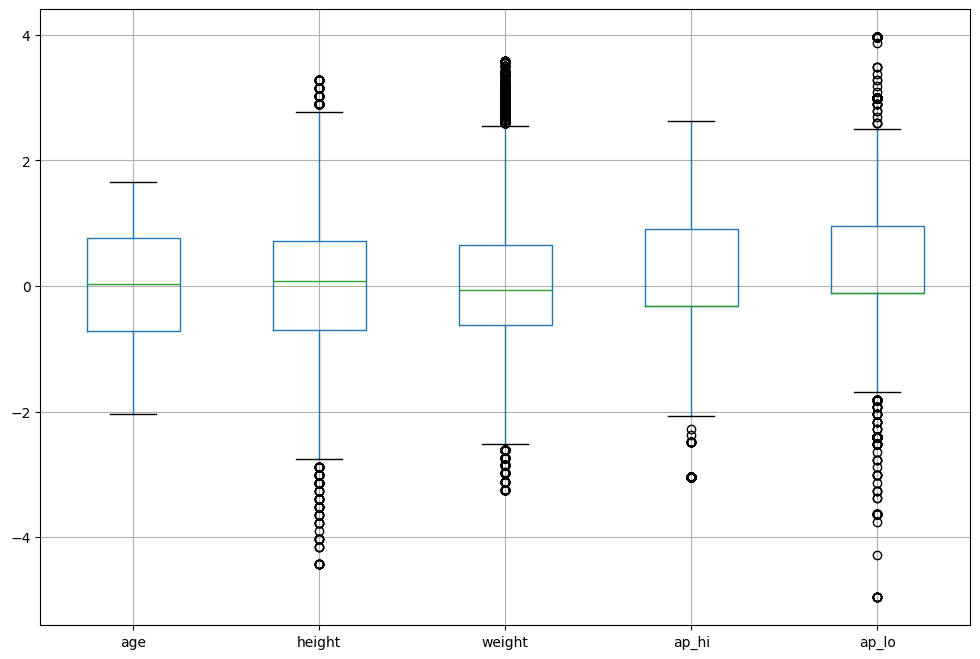

In [99]:
X_train_scaled[numerical_features].boxplot(figsize=(12,8))
plt.show()

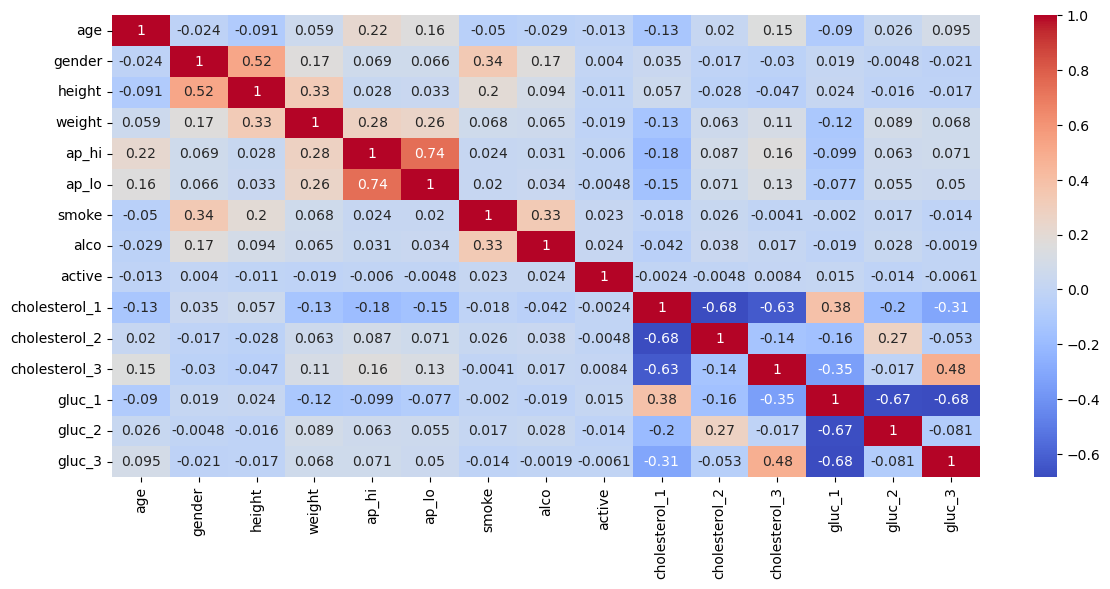

In [100]:
plt.figure(figsize=(14,6))
sns.heatmap(X_train_scaled.corr(), annot=True, cmap='coolwarm')
plt.show()

### `Train Neurol Network`

In [101]:
print(X_train_scaled.shape)

(54421, 15)


In [102]:
print(y_train.value_counts())

target
0    27649
1    26772
Name: count, dtype: int64


In [103]:
# Define the neural network model
dropout_rate = 0.4

model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(dropout_rate),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(32, activation='relu'),
    Dropout(dropout_rate),
    Dense(16, activation='relu'),
    Dropout(dropout_rate),
    Dense(8, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])


In [104]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [105]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [106]:
# Train with early stopping
history = model.fit(
    X_train_scaled, y_train, 
    epochs=10, 
    batch_size=512, 
    validation_split=0.1, 
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
96/96 [==============================] - 4s 16ms/step - loss: 0.6746 - accuracy: 0.5778 - val_loss: 0.5989 - val_accuracy: 0.7264
Epoch 2/10
96/96 [==============================] - 1s 11ms/step - loss: 0.6266 - accuracy: 0.6670 - val_loss: 0.5776 - val_accuracy: 0.7312
Epoch 3/10
96/96 [==============================] - 1s 10ms/step - loss: 0.6103 - accuracy: 0.6942 - val_loss: 0.5779 - val_accuracy: 0.7364
Epoch 4/10
96/96 [==============================] - 1s 11ms/step - loss: 0.6020 - accuracy: 0.7064 - val_loss: 0.5774 - val_accuracy: 0.7356
Epoch 5/10
96/96 [==============================] - 1s 11ms/step - loss: 0.5972 - accuracy: 0.7110 - val_loss: 0.5580 - val_accuracy: 0.7356
Epoch 6/10
96/96 [==============================] - 1s 11ms/step - loss: 0.5909 - accuracy: 0.7151 - val_loss: 0.5642 - val_accuracy: 0.7376
Epoch 7/10
96/96 [==============================] - 1s 11ms/step - loss: 0.5885 - accuracy: 0.7179 - val_loss: 0.5547 - val_accuracy: 0.7384
Epoch 8/10
96

In [107]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_dev_scaled, y_dev, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


213/213 [==============================] - 1s 4ms/step - loss: 0.5583 - accuracy: 0.7289
Test Accuracy: 0.7289
Test Loss: 0.5583


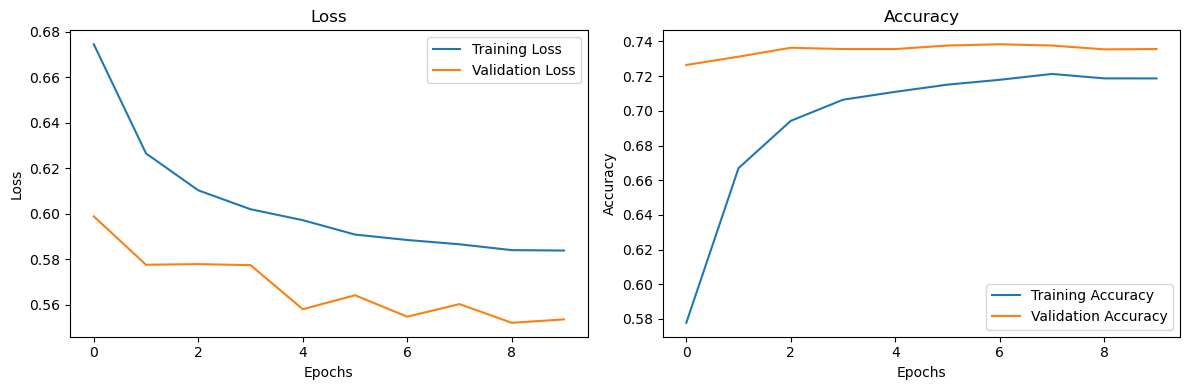

In [108]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
